# Capstone project 2: Application Recommendation System for Biodegradable Polymer

**Problem and Goal:**  
Developing new applications of a polymer is one of the most important and challenging steps to sell a polymer as a product. It requires a wide range of knowledge about polymer itself (physical property, formability, etc.) and products that might already exist or might not yet. The goal of this project is to make an application recommendation system that gives some hints about potential applications for a given polymer by a user. A biodegradable polymer has been chosen as a polymer kind for this project.

## Table of Contents

1. Load Data  
2. Exploratory Data Analysis  
3. Data Wrangling  
4. Modeling  
5. Recommend Applications (Using the Model)

## 1. Load Data

Patents are used to make the recommendation system. A patent includes information about what polymer was used, how to prepare it, for what it could be used, who invented it, and so on. The material and application data would provide useful information for this project.  
  
  
The patent data was acquired from the database of the [World Intellectual Property Organization (WIPO)](https://patentscope.wipo.int/search/en/search.jsf) with a search word “IC:(C08L 101/16)”. The dataset includes patents categorized into "C08B 101/16" and released by Jun.2.2020. C08L 101/16 is the IPC code, International Patent Classification code, for biodegradable polymers. IPC is a hierarchical patent classification system. All technical fields are divided into 8 "sections" from A to H:  
  
-A: Human Necessities  
-B: Performing Operations, Transporting  
-C: Chemistry, Metallurgy  
-D: Textiles, Paper  
-E: Fixed Constructions  
-F: Mechanical Engineering, Lighting, Heating, Weapons, Blasting  
-G: Physics  
-H: Electricity  
  
There are "classes" in each section, and each class has "subclasses". Then, there are "maingroups" under a subclass, and finally "subgroups".  For example, C08L 101/16 means:  
  
(Section)   C: Chemistry, Metallurgy  
(Class)     C08: Organic macromolecular compounds, Preparation or chemical working-up    
(Subclass)  C08L: Macromolecular compounds  
(Maingroup) C08L 101: Unspecified macromolecular compounds  
(Subgroup)  C08L 101/16: Biodegradable macromolecular compounds  
  
Each IPC code represents a material, application, or technology to manufacture it. The patent information in WIPO is collected from [193 member countries](https://www.wipo.int/members/en/). The coverage is [wide](https://patentscope.wipo.int/search/en/help/data_coverage.jsf), but not exhaustive. 
  
  
Load the data and check the general information.

In [418]:
# Import the packages
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import datetime
import matplotlib.dates as mdates
from collections import Counter
import itertools
import re
from fastText import load_model
from iso_language_codes import *
from googletrans import Translator
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import nxviz as nv
import csv

# Import a pre-trained model for language identification (from fastText)
li_model = load_model("lid.176.bin")

# Set a style for a plot
sns.set(context='notebook', style='ticks', palette='hls')
pd.set_option("display.max_colwidth", 100)

# colors
cmap1 = plt.get_cmap('tab20b') 
cmap2 = plt.get_cmap('tab20c') 

In [2]:
# You can see this notebook without codes
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

In [3]:
# Load the csv file 
raw_data_file = 'C08L10116_csv.csv'
df= pd.read_csv(raw_data_file)

print('Raw data')
print('df (first 5 rows):')
df.head()

df (first 5 rows):


,Application Id,Application Number,Application Date,Country,Title,Abstract,I P C,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红
2,CN283956286,201911046573.7,30.10.2019,CN,一种易降解环保的塑料材料,本发明公开了一种易降解环保的塑料材料及其制备方法，其原料按重量份包括有：聚乙烯20‑30份、聚烯烃共聚物15‑18份、生物降解塑料20‑25份、琼脂5‑8份、聚醇类化合物10‑15份和天然高分...,C08L 23/06; C08L 101/16; C08L 23/02; C08L 5/12; C08L 71/00; C08L 5/00; C08L 77/00,河南晖睿智能科技有限公司,李耀峰; 王莹; 刘志杰; 陈平绪; 周光灿; 李霞; 张凯强
3,US293704217,16657809,18.10.2019,US,BIODEGRADABLE URINE COLLECTOR,"<p id=""p-0001"" num=""0000"">A single-use, biodegradable, paper urine collector and method of using...",A61B 10/00; G01N 33/493; C08L 101/16; B67C 11/00,Abigail Ford MOORE,Abigail Ford MOORE
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,"<p num="""">【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。<br/>【手段】疎水性成分と親水...",C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望


In [4]:
# Rename the column names
df = df.rename(columns={'Application Id': 'Application_Id', 
                        'Application Number': 'Application_Number', 
                        'Application Date': 'Application_Date',
                        'I P C': 'IPC'})

print('Raw data after renaming the columns')
print('df (first 5 rows):')
df.head()

df (first 5 rows):


,Application_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红
2,CN283956286,201911046573.7,30.10.2019,CN,一种易降解环保的塑料材料,本发明公开了一种易降解环保的塑料材料及其制备方法，其原料按重量份包括有：聚乙烯20‑30份、聚烯烃共聚物15‑18份、生物降解塑料20‑25份、琼脂5‑8份、聚醇类化合物10‑15份和天然高分...,C08L 23/06; C08L 101/16; C08L 23/02; C08L 5/12; C08L 71/00; C08L 5/00; C08L 77/00,河南晖睿智能科技有限公司,李耀峰; 王莹; 刘志杰; 陈平绪; 周光灿; 李霞; 张凯强
3,US293704217,16657809,18.10.2019,US,BIODEGRADABLE URINE COLLECTOR,"<p id=""p-0001"" num=""0000"">A single-use, biodegradable, paper urine collector and method of using...",A61B 10/00; G01N 33/493; C08L 101/16; B67C 11/00,Abigail Ford MOORE,Abigail Ford MOORE
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,"<p num="""">【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。<br/>【手段】疎水性成分と親水...",C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望


This dataset includes worldwide patents, and the language is not limited in English. 

In [5]:
# Check the general information
print('The general information of "df":'')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8182 entries, 0 to 8181
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Application_Id      8182 non-null   object
 1   Application_Number  8135 non-null   object
 2   Application_Date    8165 non-null   object
 3   Country             8182 non-null   object
 4   Title               8172 non-null   object
 5   Abstract            7604 non-null   object
 6   IPC                 8182 non-null   object
 7   Applicants          8025 non-null   object
 8   Inventors           8027 non-null   object
dtypes: object(9)
memory usage: 575.4+ KB


This dataset includes 8,182 patents. The five columns other than 'Application_Id', 'Country', and 'IPC' have missing data.

In [172]:
# Check duplicate rows and application IDs
print('The number of duplicate rows:', list(df.duplicated()).count(True))
print('The number of duplicate application IDs:', list(df['Application_Id'].duplicated()).count(True))

The number of duplicate rows: 0
The number of duplicate application IDs: 0


Each row is unique, and there is no duplicate application ID. 

## 2. Exploratory Data Analysis

Before starting to prepare for the modeling, take a look at the data to know what should be in mind.

2.1. Countries patents were filed in    
2.2. Explore IPC codes  
2.3. Popular polymers  
2.4. Popular applications (big category)  
2.5. Popular applications in the medical category (A61)  
2.6. Language variety

### 2.1. Countries patents were filed in

The 'Country' colmmn in the data shows which country a patent was registered in. It would be connected to the market. Check the country variety and which countries are frequent.

(I will add **UNIT TEST** here later:  df['Country'] doesn't have missing values.)

In [7]:
# How many countries
print('The number of countries:', df['Country'].nunique(), 'countries')

The number of countries: 37 countries


<IPython.core.display.Javascript object>


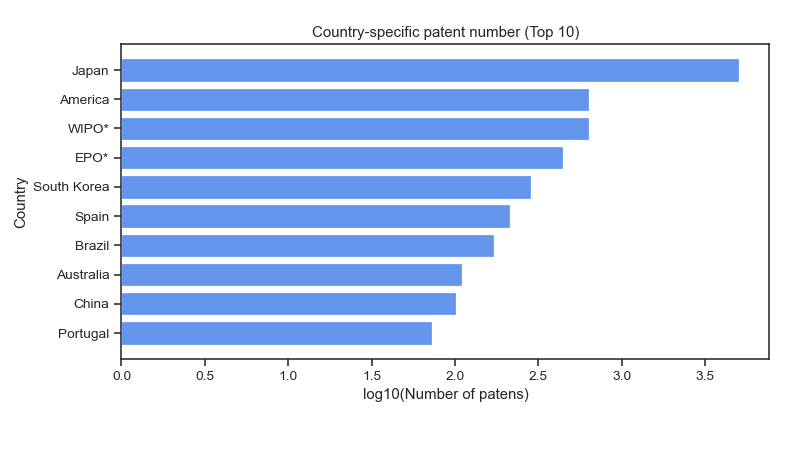

In [8]:
# Count the total patent number of each country
patent_byCountry = Counter(df['Country']).most_common()

# Extract the top 10 countries and the numbers of patents, and reverse the orders
top10_countries_list = list(reversed(patent_bycountry[:10]))

# Prepare abbreviation_country name list
abbre_country_name = {'JP': 'Japan',
                      'US': 'America',
                      'WO': 'WIPO*',
                      'EP': 'EPO*',
                      'KR': 'South Korea',
                      'ES': 'Spain',
                      'BR': 'Brazil',
                      'AU': 'Australia',
                      'CN': 'China',
                      'PT': 'Portugal'}

# Draw a bar plot of the top 10 countries
plt.figure(figsize=(9,5))

x = [np.log10(country[1]) for country in top10_countries_list]
y_abbre = [country[0] for country in top10_countries_list]
y = [abbre_country_name[abb] for abb in y_abbre]

plt.barh(y, x, color='cornflowerblue')

plt.xlabel('log10(Number of patens)')
plt.ylabel('Country')
plt.title('Country-specific patent number (Top 10)')

plt.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.90)
plt.show()

* WIPO = World Intellectual Property Organization  
* EPO = European Patent Office

The patent data is from 37 countries (and organizations). Japan and America are the largest groups. The recommended applications by the system will tend to be for products that are popular in those countries.

### 2.2. Explore IPC Codes

The DataFrame 'df' has a column called 'IPC'. This column shows the IPC codes the patent is categorized in. In this section, the following three points are explored.

2.2.1. Number of IPC codes per patent  
2.2.2. Number of IPC code kinds  
2.2.3. Frequency of each IPC code in data

#### 2.2.1. Number of IPC codes per patent 

The number of IPC codes per patent is directly related to the number of connections with other patents. If a patent has many connections with other patents, the patent is more likely to appear in the searching result. 

(I will add **UNIT TEST** here later:  df['IPC'] doesn't have missing values.)

In [40]:
# A dictionary to store the Application_Id and the IPC codes
patent_ipc_dic = {}

# Store application ids and the IPC codes in the dictionary
for i in range(len(df)):
    # Extract the IPC codes
    ipc_codes = df.loc[i, 'IPC']
    
    # Split the IPC codes and keep them in a set
    ipc_set = set(re.findall('[A-Z][0-9]+[A-Z][ ][0-9]+/[0-9]+', ipc_codes))
    
    # Remove 'C08L 101/16' (because all patents have this IPC codes)
    ipc_set.remove('C08L 101/16')
    
    # Add the ipc_set in the patent_ipc_dic
    patent_ipc_dic[df.loc[i, 'Application_Id']] = ipc_set

<IPython.core.display.Javascript object>


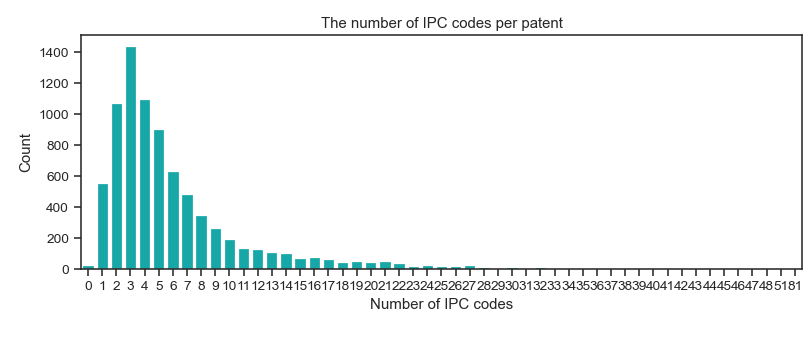

In [10]:
# Count the number of IPC codes per patent
n_ipcs_per_patent = list(map(lambda ipcs: len(ipcs), patent_ipc_dic.values()))

# Draw a count plot
plt.figure(figsize=(9,4))

sns.countplot(x=n_ipcs_per_patent, color='c')
plt.ylabel('Count')
plt.xlabel('Number of IPC codes')
plt.title('Number of IPC codes per patent')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.25, top=0.90)
plt.show()

The top of the distribution was 3. Some patents don't have any IPC codes (other than 'C08L 101/16'). They don't have any connection when the network is drawn. Check if the patents have an abstract so that it can be used to search the relationships with other patents. 

In [419]:
# Get the application_ids of patents not having any IPC code 
no_ipc_patents = [k for k, v in patent_ipc_dic.items() if len(v) == 0]

# Show the 'df' rows of the patents
print('Patents having only "C08L 101/16" as an IPC code:')
print(len(df[df['Application_Id'].isin(no_ipc_patents)]), 'patents')
df[df['Application_Id'].isin(no_ipc_patents)]

Patents having only "C08L 101/16" as an IPC code:
25 patents


,Application_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
229,MX236552233,2017005889,04.05.2017,MX,SÍNTESIS DE UN COPOLÍMERO INJERTO BIODEGRADABLE CAPAZ DE FORMAR PELÍCULA DE BAJA ADSORCIÓN.,The present invention discloses the synthesis of a biodegradable graft copolymer of low adsorpti...,C08L 101/16,UNIVERSIDAD DE GUANAJUATOUNIVERSIDAD DE GUANAJUATO,José Luis MATA MATA; Aurelio RAMÍREZ HERNÁNDEZ; Alejandro APARICIO SAGUILAN
651,MY203067723,PI 2014002784,29.09.2014,MY,A PROCESS FOR FULLY COMPOSTING BIODEGRADABLE HIGH PERFORMANCE PLASTIC MATERIALS,THE PRESENT INVENTION PROVIDES A PROCESS FOR FULLY COMPOSITING BIODEGRADABLE HIGH PERFORMANCE PL...,C08L 101/16,HENG HIAP INDUSTRIES SDN BHD,SEAH KIAN HOE
1214,CN85366070,201210198111.9,15.06.2012,CN,Production method of biodegradable medical plastics,The invention discloses a production method of environment-friendly biodegradable medical plasti...,C08L 101/16,"Yancheng Jinwo Medical Technology Co., Ltd.",Wang Jun
1477,MX130518126,2011008209,04.08.2011,MX,"PROCESO PARA LA ELABORACIÓN DE PELÍCULAS A PARTIR DE CÍTRICOS, LAS PELÍCULAS Y SU USO COMO EMPAQ...","The present invention refers to a process for the manufacture of films from citrus, the films an...",C08L 101/16,INSTITUTO TECNOLOGICO Y DE ESTUDIOS SUPERIORES DE MONTERREYINSTITUTO TECNOLOGICO Y DE ESTUDIOS S...,HUGO MUJICA PAZ; JOCELIN GABRIELA HERNANDEZ CARRILLO; JORGE WELTI CHANES; AURORA VALDEZ FRAGOSO
1631,ID202886819,P00201100008,06.01.2011,ID,SUATU MATERIAL BARU FILM PLASTIK MESRA ALAM CAMPURAN POLI (3-HIDROKSI BUTIRAT) DENGAN POLISTIREN,Suatu material baru berupa filem plastik ramah lingkungan terbuat dari campuran polistiren(PS) d...,C08L 101/16,Prof. Dr. Akmal Djamaan,Akmal Djamaan
2132,AR10512058,P090102894,29.07.2009,AR,MATERIAL COMPUESTO QUE CONTIENE MATERIAL TERMOPLASTICO Y MATERIAL PROTEINICO Y PROCEDIMIENTO DE ...,"Material compuesto que contiene material termoplástico y material proteínico, y proceso de obten...",C08L 101/16,PETROLEO BRASILEIRO S.A. - PETROBRAS -,"JURITI NAZARETH, NICOLAS; SOARES RIBEIRO, CLAUDIA MARIA; LOPES DIAS, MARCOS; MARTINS CUNHA, LAIN..."
2367,WO2009074723,PCT/FI2008/050733,12.12.2008,WO,NATURAL FIBRE BASED COMPOSITE MATERIAL,"A natural fibre based, melt processable composite material comprising a polymer matrix of a biod...",C08L 101/16,"VALTION TEKNILLINEN TUTKIMUSKESKUS; LAMPINEN, Johanna; IMMONEN, Kirsi","LAMPINEN, Johanna; IMMONEN, Kirsi"
2762,BR6371648,PI0705007-0,17.12.2007,BR,MISTURA POLIMÉRICA INJETÁVEL COM PROPRIEDADES BIODEGRADÁVEIS E PROCESSO PARA SUA OBTENÇÃO,Mistura polimérica injetável com propriedades biodegradáveis e Processo para sua obtenção. A pre...,C08L 101/16,Fundação Universidade de Caxias do Sul,Jadison Fabricio de Souza; Adriana Del Carmen Escalona Gower; Mára Zeni Andrade
2793,KR4235275,1020070121872,28.11.2007,KR,WOOD POWDER COMPOSITION FOR MOLDING WITH IMPROVED DIMENSIONAL STABILITY BY PREVENTING BENDING OR...,PURPOSE: A wood powder composition for molding is provided to reduce the danger of environmental...,C08L 101/16,"JUNG, HAE GYUN; KIM, MI YE; 정해균; 김미애","JUNG, HAE GYUN; 정해균; KIM, MI YE; 김미애"
2898,KR4045656,1020070081054,13.08.2007,KR,"MOLDING MATERIAL HAVING IMPROVED HEAT RESISTANCE, SHAPE-RETAINING PROPERTY, FLEXIBILITY, AND MOL...",PURPOSE: A molding material is provided to be formed into a desired shape by many molding method...,C08L 101/16,"SUMITOMO ELECTRIC FINE POLYMER, INC.; 스미토모덴코파인폴리머 가부시키가이샤",KANAZAWA SHINICHI; 카나자와 신이치


24 patents have only "C08L 101/16" as an IPC code, and 1 patent has an incomplete code and "C08L 101/16". 20 out of 25 patents have an English abstract, and the abstracts would be used to calculate the similarities to other patents. They will still be active in the system. On the other hand, the remaining 5 patents (ID202886819, AR10512058, BR6371648, KR149646441, DE104259751) will never show up in the result even though the information is in the network data.  

#### 2.2.2. Number of IPC code kinds

In [12]:
# Flatten the values of patent_ipc_dic (using itertools library)
flatten_values = list(itertools.chain.from_iterable(patent_ipc_dic.values()))

# Count the IPC codes
ipc_freq = Counter(flatten_values)

print('The number of IPC code kinds:', len(ipc_freq))

The number of IPC code kinds: 4344


There are 4,344 kinds of IPC codes in the data. Each IPC code represents a material, application, or technology to manufacture it. When the network is drawn, the 4,344 IPC codes will be one kind of the nodes. Another kind of the nodes will be patents (8,182). That is, the network will have 12,526 nodes in total. 

#### 2.2.3. Frequency of each IPC code in data

Here, the frequency of each IPC code is analyzed. Some IPC codes are very frequent, and some are not. This is connected with the number of edges of the network.

In [45]:
# Sort the dictionary by the frequency
ipc_freq_sorted = dict(sorted(ipc_freq.items(), key=lambda x: x[1], reverse=True))
ipc_freq_sorted_values = list(ipc_freq_sorted.values())               

print('The frequency distribution of IPC codes:')
# Show the summary statistics as a DataFrame
pd.DataFrame(pd.Series(ipc_freq_sorted_values).describe()).transpose()

The frequency distribution of IPC codes:


,count,mean,std,min,25%,50%,75%,max
0,4344.0,10.592081,60.43464,1.0,1.0,2.0,6.0,2830.0


In [46]:
# The number of IPC codes appearing only once
print('The number of IPC codes appearing only once:', ipc_freq_sorted_values.count(1))

# Percentage of IPC codes having one connection 
print('The percentage of IPC codes appearing once:', 
      round(ipc_freq_sorted_values.count(1)/len(ipc_freq)*100, 1), '%')

The number of IPC codes appearing only once: 1665
The percentage of IPC codes appearing once: 38.3 %


<IPython.core.display.Javascript object>


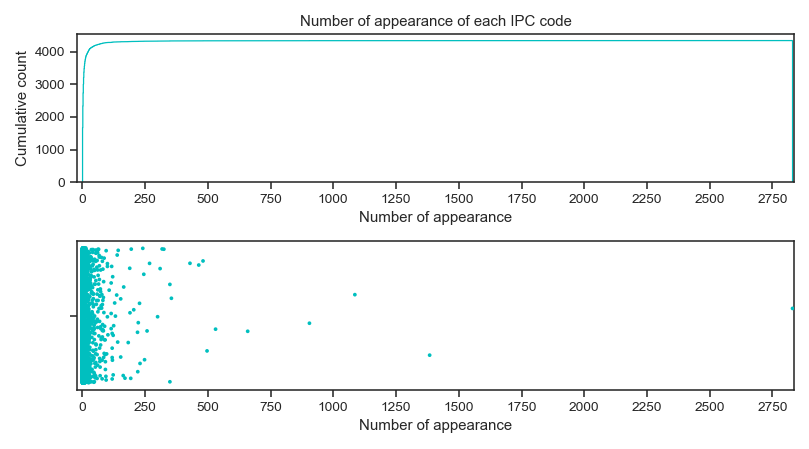

In [175]:
# Draw a count plot and a strip plot
plt.figure(figsize=(9,5))

plt.subplot(2,1,1)
plt.hist(ipc_freq_sorted_values, bins=2830, cumulative=True, histtype='step', color='c')
plt.xlim([-20, 2835])
plt.xticks(range(0, 3000, 250))
plt.xlabel('Number of appearance')
plt.ylabel('Cumulative count')
plt.title('Number of appearance of each IPC code')

plt.subplot(2,1,2)
sns.stripplot(x=ipc_freq_sorted_values, size=3, color='c', jitter=True) 
plt.xlim([-20, 2835])
plt.xticks(range(0, 3000, 250))
plt.xlabel('Number of appearance')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


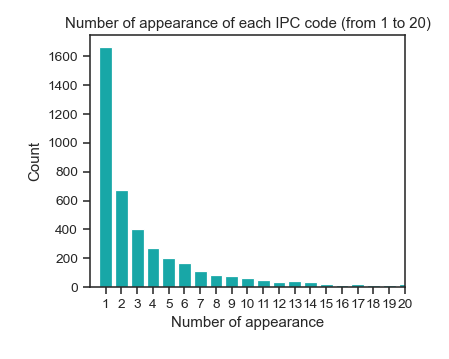

In [48]:
# Draw a bar plot of the number of appearance of each IPC code (from 1 to 20)
plt.figure(figsize=(5,4))

sns.countplot(x=ipc_freq_sorted_values, color='c')
plt.xlim([-1,19])
plt.ylabel('Count')
plt.xlabel('Number of appearance')
plt.title('Number of appearance of each IPC code (from 1 to 20)')

plt.subplots_adjust(left=0.2, right=0.90, bottom=0.2, top=0.90)
plt.show()

In [49]:
# Check the IPC codes appearing more than 500 times
print('The IPC codes appearing the most frequently (Top 5):')
ipc_freq.most_common(5)

The IPC codes appearing the most frequently (Top 5):


[('C08L 67/04', 2830),
 ('C08L 101/00', 1384),
 ('C08L 67/00', 1086),
 ('C08J 5/18', 905),
 ('C08L 67/02', 659)]

- C08L 67/04: Polyesters derived from hydroxy carboxylic acids (e.g. lactones)  
- C08L 101/00: Unspecified macromolecular compounds  
- C08L 67/00: Polyesters obtained by reactions forming a carboxylic ester link in the main chain  
- C08J 5/18: Manufacture of films or sheets      
- C08L 67/02: Polyesters derived from dicarboxylic acids and dihydroxy compounds   

1,665 (38%) IPC codes appear only once. It means they are not much useful to predict applications because the network ends at the IPC codes. However, a user might input the IPC codes and want to start from the IPC code to find other applications. So keep them. On the other hand, at least 5 IPC codes appear more than 600 times. This means once we reach the IPC codes, there are more than 600 connections. To prioritize the applications, using the similarities of abstracts would be the key. 

### 2.3. Popular polymers

Here, I extract the subclasses representing polymers, that is, 'C08L'. Then, the maingroups are counted to identify the popular polymers in the dataset. The maingroups of 'C08L' represent a polymer kind. For example, 'C08L 1' is 'cellulose', and 'C08L 67' is 'polyesters'. There are two more nested categories indicated after '/', but use the maingroup category (until just before '/') in this section.  

Extract IPC codes beginning with 'C08L'.

In [50]:
# Make a dictionary to keep an IPC code (maingroup level) as a key and the number as a value
C08L_count_dict = {}

# Extract keyes having 'C08L' and the values
for k, v in ipc_freq.items():
    if k[:4] == 'C08L':
        ipc_maingroup = re.search('C08L [0-9]+', k).group()
        if ipc_maingroup in C08L_count_dict.keys():
            C08L_count_dict[ipc_maingroup] += v
        else:
            C08L_count_dict[ipc_maingroup] = v

# Sort by the frequency
C08L_count_dict_sorted = sorted(C08L_count_dict.items(), key=lambda x:x[1]) 

# Show how many kinds of polymers are in the data
print('The number of polymer kinds:', len(C08L_count_dict_sorted))

The number of polymer kind: 49


<IPython.core.display.Javascript object>


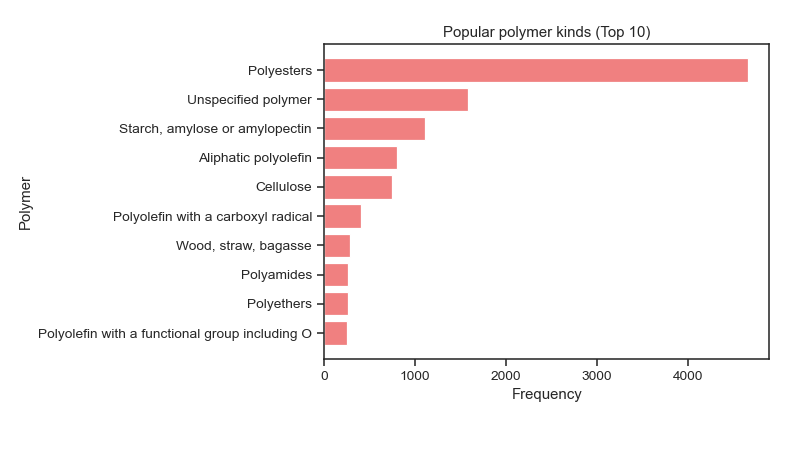

In [51]:
# Prepare a code_name dictionary
abbre_polymer = {'C08L 67': 'Polyesters',
                 'C08L 101': 'Unspecified polymer',
                 'C08L 3': 'Starch, amylose or amylopectin',
                 'C08L 23': 'Aliphatic polyolefin',
                 'C08L 1': 'Cellulose',
                 'C08L 33': 'Polyolefin with a carboxyl radical',
                 'C08L 97': 'Wood, straw, bagasse',
                 'C08L 77': 'Polyamides',
                 'C08L 71': 'Polyethers',
                 'C08L 29': 'Polyolefin with a functional group including O'
                }

# Draw a bar plot of the top 10 polymers
plt.figure(figsize=(9,5))

x_counts = [tup[1] for tup in C08L_count_dict_sorted[-10:]]
top10_polymer = [tup[0] for tup in C08L_count_dict_sorted[-10:]]
y_polymers = [abbre_polymer[abb] for abb in top10_polymer]

plt.barh(y_polymers, x_counts, color='lightcoral')

plt.xlabel('Frequency')
plt.ylabel('Polymer')
plt.title('Popular polymer kinds (Top 10)')

plt.subplots_adjust(left=0.4, right=0.95, bottom=0.2, top=0.90)
plt.show()

There are 49 kinds of polymers in the data, and polyesters are the most popular.  

### 2.4. Popular applications (big category)

First, I need to decide what IPC codes are treated as applications. I carefully checked the IPC classes and extracted the following IPC classes as applications.

### < IPC Classes for Applications >
**A: HUMAN NECESSITIES** (all classes)   
  
**B: PERFORMING OPERATIONS; TRANSPORTING** (following classes)  
- B09: DISPOSAL OF SOLID WASTE, RECLAMATION OF CONTAMINATED SOIL    
- B27: WORKING OR PRESERVING WOOD, NAILING OR STAPLING MACHINES    
- B28: WORKING CEMENT, CLAY, OR STONE  
- B31: MAKING ARTICLES OF PAPER, CARDBOARD OR MATERIAL, WORKING PAPER, CARDBOARD OR MATERIAL       
- B41: PRINTING, LINING MACHINES, TYPEWRITERS, STAMPS    
- B42: BOOKBINDING, ALBUMS, FILES, SPECIAL PRINTED MATTER    
- B43: WRITING OR DRAWING IMPLEMENTS, BUREAU ACCESSORIES   
- B44: DECORATIVE ARTS   
- B60: VEHICLES       
- B61: RAILWAYS     
- B62: LAND VEHICLES FOR TRAVELLING OTHERWISE THAN ON RAILS    
- B63: SHIPS OR OTHER WATERBORNE VESSELS, RELATED EQUIPMENT    
- B64: AIRCRAFT, AVIATION, COSMONAUTICS    
- B65: CONVEYING, PACKING, STORING, HANDLING THIN OR FILAMENTARY MATERIAL    
- B66: HOISTING, LIFTING, HAULING    
- B67: OPENING OR CLOSING BOTTLES, JARS OR SIMILAR CONTAINERS, LIQUID HANDLING    
- B68: SADDLERY, UPHOLSTERY   

**C: CHEMISTRY; METALLURGY** (following classes)   
- C02: TREATMENT OF WATER, WASTE WATER, SEWAGE, OR SLUDGE  
- C03: GLASS, MINERAL OR SLAG WOOL  
- C04: CEMENTS, CONCRETE, ARTIFICIAL STONE, CERAMICS, REFRACTORIES  
- C05: FERTILISERS
- C06: EXPLOSIVES, MATCHES  
- C09: DYES, PAINTS, POLISHES, NATURAL RESINS, ADHESIVES  
- C10: PETROLEUM, GAS OR COKE INDUSTRIES, TECHNICAL GASES CONTAINING CARBON MONOXIDE, FUELS, LUBRICANTS, PEAT  
- C11: ANIMAL OR VEGETABLE OILS, FATS, FATTY SUBSTANCES OR WAXES, FATTY ACIDS THEREFROM, DETERGENTS, CANDLES  
- C12: BIOCHEMISTRY, BEER, SPIRITS, WINE, VINEGAR, MICROBIOLOGY, ENZYMOLOGY, MUTATION OR GENETIC ENGINEERING  
- C13: SUGAR INDUSTRY  
- C14: SKINS, HIDES, PELTS OR LEATHER  
- C23: COATING METALLIC MATERIAL, COATING MATERIAL WITH METALLIC MATERIAL, CHEMICAL SURFACE TREATMENT  

**D: TEXTILES; PAPER** (following class)    
- D21: PAPER-MAKING; PRODUCTION OF CELLULOSE

**E: FIXED CONSTRUCTIONS** (all classes)   
  
**F: MECHANICAL ENGINEERING; LIGHTING; HEATING; WEAPONS; BLASTING** (all classes)    
  
**G: PHYSICS** (all classes)   

**H: ELECTRICITY** (all classes)  

These categories are used as IPC codes of applications to make a model. As a result, applications recommended by the system will be from them.

In [176]:
# Make a list of application classes of B, C, and D sections
app_codes_bcd_list = ['B09', 'B27', 'B28', 'B31', 'B41', 'B60',
                      'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C23',
                      'D21']

# Make a dictionary having an IPC code (class level) as a key and the number as a value
app_count_dict = {}

for k, v in ipc_freq.items():
    ipc_class = re.search('[A-Z][0-9]+', k).group()
    
    if (ipc_class[0] in ['A', 'E', 'F', 'G', 'H']) or (ipc_class in app_codes_bcd_list): 
        if ipc_class in app_count_dict.keys():
            app_count_dict[ipc_class] += v
        else:
            app_count_dict[ipc_class] = v
    
# Sort by the frequency 
app_count_dict_sorted = sorted(app_count_dict.items(), key=lambda x:x[1], reverse=True)

# Show the number of application kinds
print('The number of application kinds:', len(app_count_dict_sorted))

# Show the number of application codes (as a class) included in the data 
# print('The total number of application codes (class level):', sum(app_count_dict.values()))

The number of application kind: 65
The total number of application codes (as a class): 11272


In [59]:
# Make a dataframe of top 10 applicstions
df_top10_apps = pd.DataFrame(data={'Code':[code[0] for code in app_count_dict_sorted[:10]], 
                                  'Count':[code[1] for code in app_count_dict_sorted[:10]]})
print('Top 10 applications (class level):')
df_top10_apps

Top 10 applications:


,Code,Count
0,A61,5458
1,C09,1382
2,C12,714
3,A01,682
4,D21,361
5,H01,298
6,C11,241
7,C10,211
8,C02,200
9,A24,186


<IPython.core.display.Javascript object>


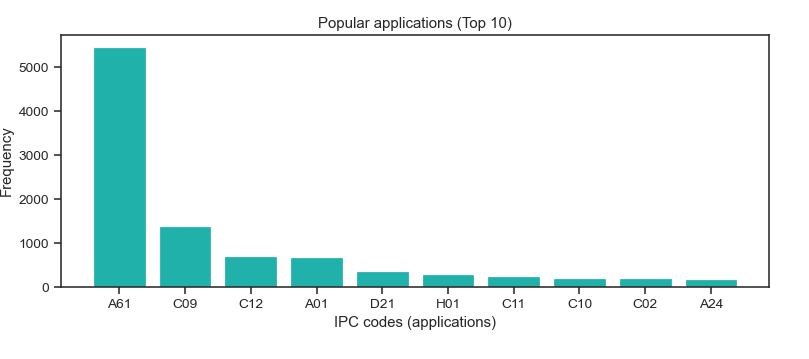

In [60]:
# Draw a bar plot showing the top 10 popular applications
plt.figure(figsize=(9,4))

x_top10_apps = [tup[0] for tup in app_count_dict_sorted[:10]]
y_counts = [tup[1] for tup in app_count_dict_sorted[:10]]

plt.bar(x=x_top10_app, height=y_counts, color='lightseagreen')

plt.xlabel('IPC codes (applications)')
plt.ylabel('Frequency')
plt.title('Popular applications (Top 10, class level)')

plt.subplots_adjust(left=0.075, right=0.95, bottom=0.2, top=0.90)
plt.show()

A61: MEDICAL OR VETERINARY SCIENCE, HYGIENE  
C09: DYES; PAINTS, POLISHES, NATURAL RESINS, ADHESIVES  
C12: BIOCHEMISTRY, BEER, SPIRITS, WINE, VINEGAR, MICROBIOLOGY, ENZYMOLOGY, MUTATION OR GENETIC ENGINEERING  
A01: AGRICULTURE, FORESTRY, ANIMAL HUSBANDRY, HUNTING, TRAPPING, FISHING  
D21: PAPER-MAKING, PRODUCTION OF CELLULOSE  
H01: BASIC ELECTRIC ELEMENTS  
C11: ANIMAL OR VEGETABLE OILS, FATS, FATTY SUBSTANCES OR WAXES, FATTY ACIDS THEREFROM, DETERGENTS, CANDLES  
C10: PETROLEUM, GAS OR COKE INDUSTRIES, TECHNICAL GASES CONTAINING CARBON MONOXIDE, FUELS, LUBRICANTS, PEAT  
C02: TREATMENT OF WATER, WASTE WATER, SEWAGE, OR SLUDGE  
A24: TOBACCO, CIGARS, CIGARETTES, SIMULATED SMOKING DEVICES, SMOKERS' REQUISITES  

According to the table and plot above, medical use (A61) is the most largest group as applications of biodegradable polymers (48% (5,458/11,272)). A61 is a class. In the A61 class, there are many subclasses, and under the subclasses, there are many maingroups, which explain more detail. Let's explore the mainclasses in A61 to determine what are the popular applications in the A61 class.

### 2.5. Popular applications in the medical category (A61)

Let's check the popular maingroups in A61.

In [63]:
# Make a dictionary to keep an IPC code (maingroup level) as a key and the number as a value
A61_count_dict = {}

# Extract keyes having 'A61' and the values
for k, v in ipc_freq.items():
    if k[:3] == 'A61':
        ipc_maingroup = re.search('A61[A-Z] [0-9]+', k).group()
        if ipc_maingroup in A61_count_dict.keys():
            A61_count_dict[ipc_maingroup] += v
        else:
            A61_count_dict[ipc_maingroup] = v

# Sort by the frequency 
A61_count_dict_sorted = sorted(A61_count_dict.items(), key=lambda x:x[1], reverse=True)

# Show the number of maingroup
print('The number of maingroups:', len(A61_count_dict_sorted))

# Show the total number of application codes as a subclass
# print('The total number of application codes (as a maingroup):', sum(A61_count_dict.values()))

The number of maingroup: 86
The total number of application codes (as a maingroup): 5458


<IPython.core.display.Javascript object>


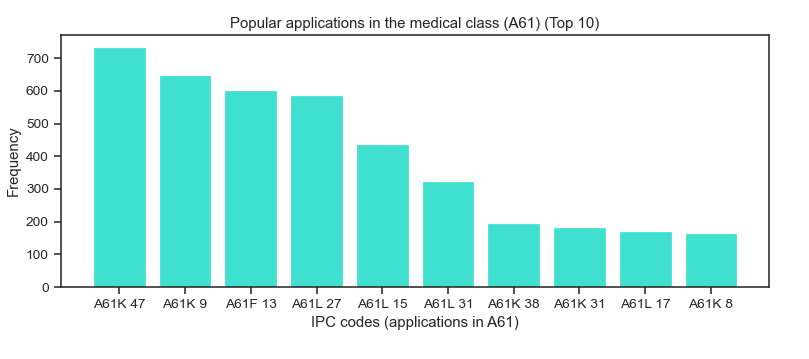

In [64]:
# Draw a bar plot showing the top 10 popular maingroups in A61
plt.figure(figsize=(9,4))

x_top10_apps_A61 = [tup[0] for tup in A61_count_dict_sorted[:10]]
y_counts = [tup[1] for tup in A61_count_dict_sorted[:10]]

plt.bar(x=x_top10_apps_A61, height=y_counts, color='turquoise')

plt.xlabel('IPC codes (applications in A61)')
plt.ylabel('Frequency')
plt.title('Popular applications in the medical class (A61) (Top 10, maingroup level)')

plt.subplots_adjust(left=0.075, right=0.95, bottom=0.2, top=0.90)
plt.show()

A61K 47: Medicinal preparations (the non-active ingredients used, e.g. carriers or inert additives), targeting or modifying agents (chemically bound to the active ingredient)    
A61K 9: Medicinal preparations (special physical form)   
A61F 13: Bandages, dressings, absorbent pads  
A61L 27: Prostheses, coating prostheses  
A61L 15: Chemical aspects of materials for bandages, dressings or absorbent pads  
A61L 31: Other surgical articles  
A61K 38: Medicinal preparations (containing peptides)  
A61K 31: Medicinal preparations (containing organic active ingredients)  
A61L 17: Surgical sutures, ligaturing blood vessels  
A61K 8: Cosmetics or toilet preparations  

'A61 47', 'A61 9', 'A61L 27', 'A61K 38', 'A61K 31', and 'A61L 17' could be used inside our body. So it makes sense that the material would be required to biodegrade in our body.    
'A61F 13', 'A61L 15', 'A61L 31', and 'A61K 8' are used outside of our body. The 'biodegrade' might mean that the material biodegrades by water, bacteria, or enzyme in a nature environment.

### 2.6. Language variety

According to the first five rows of the 'df', it includes at least Spanish, Chinese, English, and Japanese. Because I'm going to use abstracts to calculate the similarities between patents, it's important to know what languages are used and the percentage of each. We already know that the 'Abstract' column has missing values. First, take a look at the rows having NaN in the "Abstract" column.

In [420]:
# Extract the patents having NaN in the "Abstract" column
df_abst_nan = df[df['Abstract'].isna()]

print('The number of patents without an abstract:', len(df_abst_nan))
print('df_abst_nan (first two rows):')
df_abst_nan.head(2)

The number of patents without an abstract: 578
df_abst_nan (first two rows):


,Application_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
46,AU236516509,2018282377,20.12.2018,AU,BIO-BASED POLYETHYLENE TEREPHTHALATE PACKAGING AND METHOD OF MAKING THEREOF,NaN,C08G 63/183; B65D 65/46; C08L 67/03; C08L 101/16; D01F 6/62,The Coca-Cola Company,NaN
74,JP293331120,2018545678,30.07.2018,JP,リグニンの製造方法,NaN,C08H 7/00; C08L 97/00; C08L 101/16,東レ株式会社,荒井 喬広; 栗原 宏征; 舩田 茂行; 山田 勝成


There are 578 patents without an abstract. At least some of them seem to have a title. It will be better to use a title as an abstract than without it. Check how many patents don't have a title nor an abstract.

In [66]:
# Extract the patents having NaN in the "Title" and "Abstract" columns
df_title_abst_nan = df_abst_nan[df_abst_nan['Title'].isna()]

print('The number of patents without a title or an abstract:', len(df_title_abst_nan))

The number of patents without a title or an abstract: 9


In [186]:
# Show the 9 patents without a title and abstract
print('The 9 patents without a title and abstract:')
df_title_abst_nan

,Application_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
7967,US38196312,07414964,29.09.1989,US,NaN,NaN,C08G 63/91; C08G 63/84; A61K 47/48; A61K 47/48; C07F 5/00; C07F 5/00; C08G 63/00; C08G 63/08; C08G 63/82; C08G 63/84; C08J 5/18; C08J 5/18; C08J 7/00; C08J 7/04; C08L 101/00; C08L 101/16,DU PONT,STEPHAN J MCLAIN; NEVILLE E DRYSDALE
8052,GR228996259,810164951,14.05.1981,GR,NaN,NaN,A61K 9/58; A61K 9/00; A61K 9/20; A61K 9/22; A61K 9/70; A61K 31/765; A61K 47/34; A61K 47/48; C08G 63/66; C08G 65/00; C08G 65/28; C08G 65/34; C08G 67/00; C08K 5/00; C08L 71/02; C08L 101/16,SRI INTER NATIONAL,HELLER JORGE; HELWING ROBERT FRANK; PENHALE DONALD WILLIAM HENRY
8070,GR228990772,800162846,09.09.1980,GR,NaN,NaN,C08G 63/00; A61K 9/22; A61K 47/34; C08G 63/06; C08G 63/82; C08L 101/16,ROBERT STEPHEN NEVIN,NEVIN ROBERT STEPHEN
8136,DK191243254,104575,14.03.1975,DK,NaN,NaN,C07D 253/08; A01N 43/707; A23K 1/16; A23K 1/17; C07D 253/10; C08L 101/16,CIBA GEIGY AG,DIEL P J
8137,FR187029813,7508014,14.03.1975,FR,NaN,NaN,C07D 253/08; A01N 43/707; A23K 1/16; A23K 20/195; C07D 253/10; C08L 101/16,CIBA GEIGY AG,NaN
8141,FR186821567,7503571,05.02.1975,FR,NaN,NaN,C12P 19/12; B29C 45/00; B29C 47/00; B29C 47/78; B29C 59/00; C08J 9/04; C08L 5/00; C08L 101/16,SUMITOMO CHEMICAL CO,NaN
8152,FR187764018,7425620,24.07.1974,FR,NaN,NaN,C08F 16/00; C08F 16/38; C08F 20/44; C08F 220/00; C08F 220/42; C08F 279/02; C08L 101/16,ICI LTD,NaN
8155,FR185556104,7316542,08.05.1973,FR,NaN,NaN,C08G 18/00; C08K 5/00; C08L 1/00; C08L 3/00; C08L 23/00; C08L 27/00; C08L 75/00; C08L 75/06; C08L 101/00; C08L 101/16; D01F 1/10,COLOROLL LTD,NaN
8162,FR187829230,7203573,03.02.1972,FR,NaN,NaN,B65D 1/00; B65D 25/34; B65D 65/40; C08L 61/06; C08L 97/00; C08L 97/02; C08L 101/16,BIOCOR CORP,NaN


9 patents didn't have the title nor abstract. It's 0.1% (9/8182). I leave them as is because all of the 9 patents have many IPC codes and the IPC codes can be used to search the relationships with other patents at least. Fill the abstracts with the titles for patents having a title but not having an abstract.

In [421]:
# Make a new DataFrame to hold the data after filling the abstracts by the titles
df_with_abst = pd.DataFrame(columns=df.columns)

# Fill out the abstract if the patent has a title but not an abstract. 
for i in tqdm(range(len(df))):
    df_with_abst = df_with_abst.append(df.iloc[i])
    if type(df.loc[i, 'Abstract']) == float:
        df_with_abst.loc[i, 'Abstract'] = df_with_abst.loc[i, 'Title']
        
print('df_with_abst (first two rows):')
df_with_abst.head(2)

100%|█████████████████████████████████████| 8182/8182 [00:26<00:00, 314.11it/s]

df_with_abst (first two rows):


,Application_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红


According to exploring the abstracts, some HTML tags and line feed codes ('\n') are included in abstracts. They can be an obstacle to identify the languages. Remove them before identifying what kind of languages are used.

In [422]:
# Remove HTML tags and line feed codes 
for i in range(len(df_with_abst)):
    if type(df_with_abst['Abstract'][i]) == str:
        # Remove HTML tags
        text = re.sub(r'<.+?>', '', df_with_abst['Abstract'][i])
        
        # Remove '\n' 
        df_with_abst['Abstract'][i] = text.replace('\n', '')

print('After removing HTML tags and line feed codes')
print('df_with_abst (first two rows):')
df_with_abst.head(2)

After removing HTML tags and line feed codes
df_with_abst (first two rows):


,Application_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红


Here, a [language identification model](https://fasttext.cc/docs/en/language-identification.html) by [fastText](https://fasttext.cc/) is used to identify the languages of abstracts. FastText is a library developed by Facebook. The pre-trained model ('lid.176.bin') predicts the language used in a given text. It can recognize 176 languages.  
  
The function `predict_language` pridicts the language of a given text. If the result is sure more than 70%, the predicted language is returned, and if it is less than 70%, 'unsure' is returned. Here, I chose 70% as a cut-off point because of the balance between the accuracy and the number of 'unsure.' The accuracy is still very good at 70% (you will see it later.)

In [423]:
# Define a function predicting the language
def predict_language(text):
    '''identify language, and return it if it is sure more than 70%'''
    
    # Lower the text
    text = text.lower()
    
    # Predict language
    label, prob = li_model.predict(text)
    
    # Return the language if more than 70% sure
    if prob > 0.7:
        return label[0].replace("__label__", "")
    else:
        return 'unsure'

In [424]:
# Make a new column to store the predicted languages
df_with_abst['Language'] = ''

# Predict the languages
for i in range(len(df_with_abst)):
    if type(df_with_abst['Abstract'][i]) == float:
        df_with_abst.loc[i, 'Language'] = 'no abstract'
    else:
        language = predict_language(df_with_abst.loc[i, 'Abstract'])
        df_with_abst.loc[i, 'Language'] = language
            
print('df_with_abst (first two rows):')
df_with_abst.head(2)

df_with_abst (first two rows):


,Application_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors,Language
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN,es
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红,zh


Check if the languages were correctly identified. 100 datapoints are randomly selected from the dataframe using the following codes. Then, I check the accuracy by hand.

In [192]:
# Error analysis
# Extract 100 random samples from df_with_abst
df_accuracy_check = df_with_abst.sample(n=100, random_state=1)[['Application_Id', 'Country', 'Abstract', 'Language']]

In [425]:
# Please change the numbers inside iloc[] to check the accuracy
print('Random samples from df_with_abst:')
df_accuracy_check.iloc[90:]

Random samples from df_with_abst:


,Application_Id,Country,Abstract,Language
1681,JP273410613,JP,工程（ａ）から（ｃ）を含むポリラクチドフィルムの形成方法。工程（ａ）では、剥離剤コーティングを備える処理されたツール表面が提供される。この処理されたツール表面は、ポリラクチドのガラス転移温...,ja
5340,JP269633797,JP,PROBLEM TO BE SOLVED: To provide a new polymer useful as a polymer surface-active agent or an em...,en
6233,JP268554415,JP,PROBLEM TO BE SOLVED: To obtain a flame-retarded composition excellent in workability on a sheet...,en
4029,WO2005059014,WO,"A biodegradable foam that excels in biodegradability, moldability and heat resistance and that e...",en
2774,JP271756167,JP,PROBLEM TO BE SOLVED: To provide a biomass derived fiber reinforced flame-retardant resin compos...,en
2270,JP272273207,JP,PROBLEM TO BE SOLVED: To provide a method for producing a new and useful biodegradable resin com...,en
3390,JP271278925,JP,PROBLEM TO BE SOLVED: To obtain a resin composition having a low environmental load that excels ...,en
3125,JP272189887,JP,新規な生分解性リン酸エステルポリアミンを開示する。この生分解性リン酸エステルポリアミンは、組織の接着剤または封止剤として使用することができる吹付可能組成物のための架橋剤として利用することができ...,ja
8041,EP11519558,EP,BIORESORBABLE POLYESTERS AND POLYESTER COMPOSITES,unsure
4356,BR6308693,BR,"""PROCESSO DE FABRICAçãO DE MOLDAGEM DE CELULOSE, APARELHO DE EXTRAçãO DE COMPONENTE DE PLANTA E ...",pt


The accuracy was 100% at the 100 randam samples. I assume the other datapoints are also accurate. Next, check the number of datapoints having NaN in the abstract and the number of patents in which the language is not sure.

In [193]:
print('The numebr of patents having NaN in the abstract:', len(df_with_abst[df_with_abst['Language'] == 'no abstract']))
print('The number of patents in which the language is not sure:', len(df_with_abst[df_with_abst['Language'] == 'unsure']))

The numebr of patents having NaN in the abstract: 9
The number of patents in which the language is not sure: 130


The 9 patents were already discussed. They don't have a title nor an abstract. 130 (1.6%) patents had a low prediction rate. Check them and identify the language by hand.

In [194]:
# Extract the patents which language is 'unsure' 
df_unsure_language = df_with_abst[df_with_abst['Language'] == 'unsure'][['Application_Id', 'Country', 'Abstract', 'Language']]

print('df_unsure_language (first 5 rows):')
df_unsure_language.head()

df_unsure_language (first 5 rows):


,Application_Id,Country,Abstract,Language
77,WO2019022502,WO,"Provided are: a method for preparing biodegradable polymer microparticles and, particularly, porous microparticles of a biodegradable polymer; and biodegradable polymer microparticles prepared thereby, particularly, porous microparticles of a biodegradable polymer.",unsure
906,EP254727492,EP,BIODEGRADABLE POLYMERIC NANOCOMPOSITE MATERIALS AND APPLICATIONS OF THE SAME,unsure
987,PT232813269,PT,BIODEGRADABLE MATERIAL AND METHOD FOR PRODUCING BIODEGRADABLE MATERIAL,unsure
988,PT278275348,PT,BIODEGRADABLE MATERIAL AND METHOD FOR PRODUCING BIODEGRADABLE MATERIAL,unsure
991,ES105853532,ES,Contenedor biodegradable para inóculos fúngicos,unsure


Each patent has the 'Country' column. It will be connected to the language kind of the patent. For example, when a patent is registered in a country in which an official language is English, the patent would be written in English. First, check the country variety in df_unsure_language.

In [195]:
# Show the unique values in the 'Country' column
print('The unique values in the "Country" column:')
df_unsure_language['Country'].unique()

The unique values in the "Country" column:


array(['WO', 'EP', 'PT', 'ES', 'JP', 'ID', 'US', 'BR', 'EE', 'IT', 'GR',
       'PH', 'AU', 'AR', 'NZ', 'RO', 'DK', 'GB', 'SE'], dtype=object)

Some countries in the list use English as an official language; US (America), PH (Philippines), AU (Australia), 'NZ (New Zealand), and GB (United Kingdom). Also, WO (WIPO, World Intellectual Property Organization) and EP (EPO, European Patent Office) use English for their publication. The patents from the countries and organizations should be written in English. I have decided to label them as 'en'. Then, check the languages of rest of the patents. 

In [196]:
# Make a list of the countries in which English is used as an official language 
english_countries = ['WO', 'US', 'PH', 'AU', 'NZ', 'EP', 'GB']

# Countries in which English is not used as the first language 
non_english_countries = set(df_unsure_language['Country'].unique()) - set(english_countries)

# Check the language by hand
print('Show the abstracts having a country code of non-English country to identify the languages:')
for country in non_english_countries:
    print('-------------------------------------------------------------------------')
    print('Country code:', country)
    print(df_unsure_language[df_unsure_language['Country'] == country]['Abstract'])

Show the abstracts having a country code of non-English country to identify the languages:
-------------------------------------------------------------------------
Country code: IT
5255                      COPOLIMERI A BLOCCHI AMORFO-CRISTALLINI
5257    COPOLIESTERI TERMOPLASTICI SATURI/INSATURI BIODEGRADABILI
5258    COPOLIESTERI TERMOPLASTICI SATURI/INSATURI BIODEGRADABILI
7233                    BASTONCINI COTONATI IN MATERIALE PLASTICO
7999                   POLISACCARIDI CARBOSSIILICI AUTORETICOLATI
Name: Abstract, dtype: object
-------------------------------------------------------------------------
Country code: JP
1348                                                                                                                                                                                                                                                                                                                                                                           

In [197]:
# Identify the language of each country code from the table above
country_language = {'ES':'es', 'IT':'it', 'ID':'id', 'EE':'et', 'BR':'pt', 'DK':'da', 'JP':'ja', 'RO':'en', 'SE':'sv',
                    'PT':'pt', 'AR':'es', 'GR':'en'}

# Make a dictionary for exceptional patents
index_language = {987:'en', 988:'en', 8054:'en', 3738:'en', 4305:'en'}

In [198]:
# Assign the new labels
for i in range(len(df_with_abst)):
    if df_with_abst.loc[i, 'Language'] == 'unsure':
        if df_with_abst.loc[i, 'Country'] in english_countries:
            df_with_abst.loc[i, 'Language'] = 'en'
            
        else:    
            df_with_abst.loc[i, 'Language'] = country_language[df_with_abst.loc[i, 'Country']]
            if i in index_language.keys():
                df_with_abst.loc[i, 'Language'] = index_language[i]

print('The numebr of patents having NaN in the abstract:', len(df_with_abst[df_with_abst['Language'] == 'no abstract']))
print('The number of patents in which the language is not sure:', len(df_with_abst[df_with_abst['Language'] == 'unsure']))

The numebr of patents having NaN in the abstract: 9
The number of patents in which the language is not sure: 0


Now all patents have a language label in the 'Language' column except for the 9 patents. Check the top 5 languages.

In [199]:
# Make a dictionary showing the languages and the frequencies 
count_language = df_with_abst['Language'].value_counts().to_dict()

# Make a DataFrame of top 5 applications
df_count_lang = pd.DataFrame(data={'Language code':list(count_language.keys()), 
                                   'Count':list(count_language.values())})
# Show the top 5 languages
print('The number of language kinds:', len(count_language))
print('Top 5 languages:')
df_count_lang.head()

The number of language kinds: 19
Top 5 languages:


,Language code,Count
0,en,6687
1,ja,799
2,es,237
3,pt,184
4,ko,59


81.7% (6687/8182) of the abstracts is written in English. The accuracy of the language identification was already checked, but check it again after removing English abstracts so that we can see the rest of them enough.

In [413]:
# Error analysis
# Extract non-English rows
df_with_abst_except_en = df_with_abst[df_with_abst['Language'] != 'en']
df_accuracy_check2 = df_with_abst_except_en.sample(n=100, random_state=1)[['Application_Id', 'Country', 'Abstract', 'Language']]

# Please change the numbers inside iloc[] to check the accuracy
df_accuracy_check2.iloc[95:100]

,Application_Id,Country,Abstract,Language
5477,JP269947872,JP,酵素合成アミロースから得られる生分解性物品,ja
3010,ES144955331,ES,"Composición de plástico biodegradable, artículo moldeado a partir de la composición y método para controlar la velocidad de biodegradación",es
5374,BR6275281,BR,"""COPOLìMEROS BIODEGRADáVEIS DE POLIHIDROXIALCANOATO COM PROPRIEDADES MELHORADAS DE CRISTALIZAçãO"". A invenção refere-se a composições que têm propriedades físicas e de cristalização melhoradas, que contêm (a) uma fase contínua de um primeiro polihidroxialcanoato biodegradável que compreende um copolímero ou uma mistura de copolímeros, de pelo menos duas unidades de repetição aleatória (RRMU), que a primeira unidade de repetição tem a estrutura (I): em que R^ 1^ é H, C^ 1^ alquila ou C2 alquila, n é 1 ou 2 e a segunda RRMU é diferente da primeira RRMU e compreende pelo menos um monómero selecionado do grupo consistindo nas estruturas (II) e (III): em que R^ 2^ é uma C3-C19 alquila ou C3-C19 alquenila, e em que m é 2 a cerca de 16, e em que o copolímero tem um ponto de fusão Tm1, e (b) um segundo homopolímero ou copolímero de polihidroxialcanoato cristalizável e biodegradável que compreende pelo menos uma unidade monomérica de repetição aleatória que tem a estrutura (IV): em que R^ 3...",pt
1559,JP272882062,JP,【課題】ポリエステルポリオール由来のポリウレタンとしての特性である耐熱、耐候性、耐水性を維持したまま、地球環境に優しく、ポリウレタン反応の制御がし易く、更にポリウレタンの伸度や弾性率の優れたポリウレタンを得るための新たなポリエステルポリオール、およびこのポリエステルポリオールを用いたポリウレタンを提供する。【解決手段】ジカルボン酸および脂肪族ジオールを反応させポリエステルポリオールを製造する工程と、ポリエステルポリオールおよびポリイソシアネート化合物を反応させる工程とを少なくとも含むポリウレタンの製造方法であって、ジカルボン酸がバイオマス資源から誘導された少なくとも一つの成分を含み、ジカルボン酸中の有機酸の含有量が０ｐｐｍ超１０００ｐｐｍ以下であり、該有機酸の２５℃におけるｐＫａ値が３．７以下である製造方法。【選択図】なし,ja
7762,JP265774282,JP,【構成】 下記の３成分（Ａ）～（Ｃ）を主成分とする プリント基板マスキングテープ用硬化性組成物； （Ａ）分子中に少なくとも１個のアルケニル基を有する 化合物、 （Ｂ）分子中に少なくとも２個のヒドロシリル基を有す る化合物、 （Ｃ）ヒドロシリル化触媒。 【効果】 スクリーン印刷可能な粘度と充分なポットラ イフを有し、硬化時間が短く、得られたマスキングテー プには残タックがなく、ハンダ浴浸漬後の劣化もなく、 プリント基板耐熱マスキングテープ用に好適である。,ja


The accuracy was 100% at the 100 randam samples again. I assume the other datapoints are also accurate. Draw the plot of the language variety. 

<IPython.core.display.Javascript object>


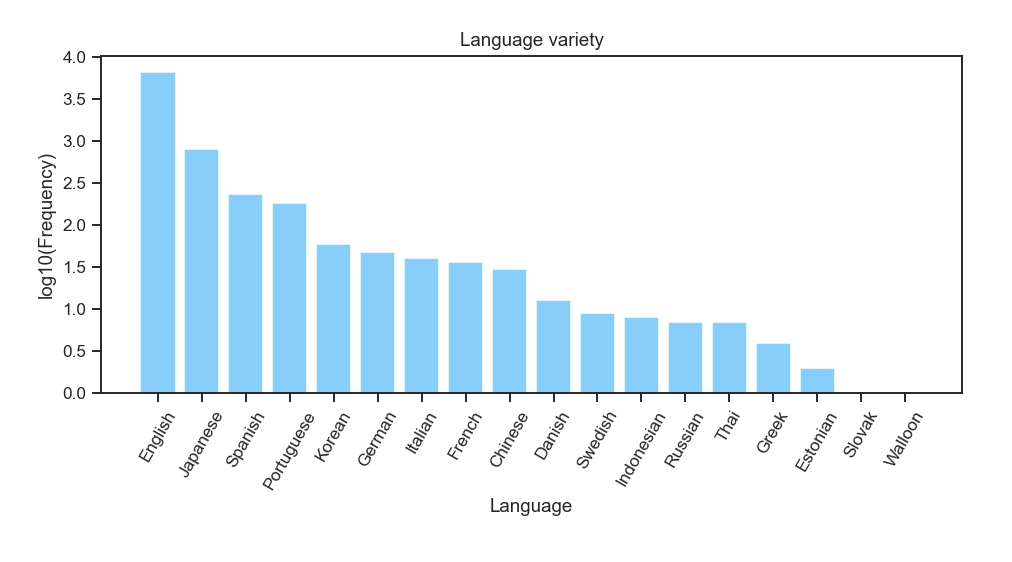

In [204]:
# Remove 'no abstract' from count_language to draw a plot
count_language.pop('no abstract')

# Draw a bar plot of the language variety
plt.figure(figsize=(9,5))

# Exchange the abbriviations into the full names (using iso_language_codes)
x_languages = [language_name(lan) for lan in count_language.keys()]

# Transform the counts into logarithm 
y_counts = [np.log10(val) for val in count_language.values()]

plt.bar(x_languages, y_counts, color='lightskyblue')

plt.xlabel('Language')
plt.ylabel('log10(Frequency)')
plt.title('Language variety')

plt.xticks(rotation=60)

plt.subplots_adjust(left=0.1, right=0.95, bottom=0.3, top=0.90)
plt.show()

81.7% (6687/8182) of the abstracts is written in English. 9.8% (799/8182) is written in Japanese. The abstracts in English and Japanese will be used to calculate the similarity of patents. On the other hand, the IPC codes can be used to analyze the relationships even if a patent is written in the other languages. So I'll keep them too. 

## 3. Data Wrangling  

The purpose of this section is to make the data ready for modeling. I deal with the 'Abstract' column to prepare for calculating the similarities between patents.

3.1. Translate Japanese to English  
3.2. Tokenization  
3.3. Clean up tokens   
3.4. Adjust the number of tokens per patent

### 3.1. Translate Japanese to English

9.8% of the abstracts were written in Japanese. Here, translate those abstracts into English to use them to calculate the similarities between patents.

In [215]:
# Extract patents having Japanese abstracts
df_ja_abst = df_with_abst[df_with_abst['Language'] == 'ja']

print('df_ja_abst (first row):')
df_ja_abst.head(1)

df_ja_abst (first row):


,Application_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors,Language
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。【手段】疎水性成分と親水性成分との共重合体である脂肪族ポリエスエルであって、該親水性成分が、ポリ（１，５−ジオキセパン−２−オン）、ポリ（１，４−ジオキサン−２−オン）、または、ポリエチレンオキシドの少なくとも１つを含み、該親水性成分のモル比が５％以上８５％以下である、抗血小板粘着性を示す生分解性共重合体。【選択図】図２,C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; A61L 31/12; A61L 31/14; A61L 33/06; C08L 101/16,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望,ja


In [206]:
# Check the abstracts
df_ja_abst['Abstract'].sample(5)

2772                                                                                                生分解性ポリマーおよび環境適合性の非VOCであるギ酸メチルを発泡剤として用い、膨張および押出生分解性ポリマー発泡体を得る。発泡剤は、少なくとも１つの共発泡剤、好ましくは環境に適合する種（例えば非ＳＯＣ）をさらに含む発泡剤ブレンドであってよく、ここで共発泡剤は物理共発泡剤（例えば、無機薬剤、炭化水素、ハロゲン化炭化水素、極性の官能基を有する炭化水素、水、またはこれらの任意の組み合わせ）または化学共発泡剤のいずれか、あるいはこれらの組み合わせである。発泡剤ブレンドは、ギ酸メチルと一以上の共発泡剤との任意の組み合わせであってよい。ポリマー発泡体は、生分解性ポリマー、またはそれと他の生分解性ポリマーもしくは従来型ポリマー（非生分解性ポリマー）とのブレンドを含んでいてよい。ギ酸メチル系発泡剤ブレンドにより、断熱材、保護用緩衝材と同様、容器、包装システムを含む種々の用途向けの安定な発泡体が得られる。このような発泡体の製造方法も提供する。
575                                                                                                                                                                                                                                                                                                                                                                                                       アルデヒド反応性官能基を有するポリマーとポリアルデヒドとの反応生成物である生分解性架橋ポリマーであって、アルデヒド反応性官能基を有するポリマーが生分解性構造体を含むか、または

The abstracts have a format. Each abstract has '【課題】'(problem) and '【解決手段】'(means for solving the problems).They are a title of the following sentenses. Also, the expressions after '【選択図】' (figure) mean the explanation about the figure originally included in the database. Remove them.

In [416]:
# Remove titles 
for i in range(len(df_ja_abst)):
    
    # Remove '【選択図\】' plus a following number
    text = re.sub(r'\【選択図\】.*', '', df_ja_abst.loc[df_ja_abst.index[i], 'Abstract'])
    
    # Remove titles
    df_ja_abst.loc[df_ja_abst.index[i], df_ja_abst.columns.get_loc('Abstract')] = re.sub(r'\【.+?\】', '', text)

# print('df_ja_abst (first row):')
# df_ja_abst.head(1)

In [218]:
# Take a look at one full abstract again
df_ja_abst.iloc[0, df_ja_abst.columns.get_loc('Abstract')]

'生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。疎水性成分と親水性成分との共重合体である脂肪族ポリエスエルであって、該親水性成分が、ポリ（１，５−ジオキセパン−２−オン）、ポリ（１，４−ジオキサン−２−オン）、または、ポリエチレンオキシドの少なくとも１つを含み、該親水性成分のモル比が５％以上８５％以下である、抗血小板粘着性を示す生分解性共重合体。'

They have been removed. Next, translate Japanese to English. Here, I use a translation library called [googletrans](https://py-googletrans.readthedocs.io/en/latest/), which is developed by Google. It is free, but there is a restriction that is maximum 15k words in 24 hours from one IP address. I divide df_ja_abst into two part so that each of them have less than 15k words. (If you want to avoid the restriction, there is a [paid version](https://cloud.google.com/translate/docs).) I save df_ja_abst with the translated abstracts as a cvs file. If you need it, go to 4 more cell from here. 

In [89]:
# The first half
#  Make a new column to store translated abstracts
df_ja_abst = df_ja_abst.assign(Translated_Abstract = '')

# Copy df_ja_abst
df_ja_abst_copy = df_ja_abst.copy()

# Translate Japanese abstracts into English (using googletrans)
for i in tqdm(range(400)):
    # Generate a translator 
    translator = Translator()

    # Translate the sentences of the 'Abstract' column 
    en_text = translator.translate(df_ja_abst_copy.loc[df_ja_abst_copy.index[i], 'Abstract'])
    
    # Store them in the 'Translated Abstract' column
    df_ja_abst.loc[df_ja_abst.index[i], 'Translated_Abstract'] = en_text.text

In [426]:
# The second half
# Translate Japanese abstracts into English
for i in tqdm(range(400, len(df_ja_abst))):
    # Generate a translator (googletrans)
    translator = Translator()

    # Translate the sentences of the 'Abstract' column 
    en_text = translator.translate(df_ja_abst_copy.loc[df_ja_abst_copy.index[i], 'Abstract'])
    
    # Store them in the 'Translated Abstract' column
    df_ja_abst.loc[df_ja_abst.index[i], 'Translated_Abstract'] = en_text.text
    
print('df_ja_abst (first row):')
df_ja_abst.head(1)  

100%|████████████████████████████████████████| 399/399 [05:06<00:00,  1.30it/s]

df_ja_abst (first row):


,Application_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors,Language,Translated_Abstract,5
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。疎水性成分と親水性成分との共重合体である脂肪族ポリエスエルであ...,C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望,ja,"It combines the biodegradability and antithrombotic, also excellent in shape stability, to provi...",生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。疎水性成分と親水性成分との共重合体である脂肪族ポリエスエルであ...


In [463]:
# Save the dataframe as a csv file
# df_ja_abst.to_csv('df_ja_abst.csv')

In [220]:
# If you need the result (df_ja_abst with the translated abstracts)
# Load the csv file 
df_ja_abst_file = 'df_ja_abst3.csv'
df_ja_abst = pd.read_csv(df_ja_abst_file, index_col=0)

Check if the translation is right. Radomly extract 80 samples (rows) from df_ja_abst, and check the accuracy.

In [221]:
# Error analysis: take a look at 80 samples of the translated sentenses to identify the translation was right 
# Extract 80 random samples
df_accuracy_check3 = df_ja_abst.sample(n=80)[['Application_Id', 'Abstract', 'Translated_Abstract']]

In [427]:
# Please change the numbers inside iloc[] to check the accuracy (from 0 to 80)
pd.set_option("display.max_colwidth", 1000)
df_accuracy_check3.iloc[75:80]

,Application_Id,Abstract,Translated_Abstract
5024,JP270339922,ポリ乳酸系樹脂二軸延伸フィルム,Polylactic acid resin biaxially oriented film
723,JP274522007,組織シーラントおよび接着剤として使用するためのプレポリマー、ならびにそれらを作る方法、およびそれらを使用する方法が提供される。プレポリマーは、注射器またはカテーテルを通して適用され得るような流れ特性を有するが、適用部位の場所に留まり、組織から流れ落ちないほど十分に粘性である。プレポリマーは、体液による洗い流しに耐えるのに十分な疎水性でもある。プレポリマーは、体液中で安定である；すなわち、プレポリマーは、架橋を開始するために意図的に加えられる刺激が存在しなければ、体液中で自発的に架橋しない。架橋の際に、接着剤は、血液および他の体液の存在下で有意な接着強度を呈する。接着剤は十分に弾性であり、下層組織の運動に耐えることができる。接着剤は、止血シールとして提供することができる。接着剤は生分解性かつ生体適合性であり、最小限の炎症応答しか引き起こさない。,"Tissue sealant and prepolymers for use as adhesives and methods of making them, and methods of using them are provided. Prepolymer has the flow characteristics such as may be applied through a syringe or catheter, remains in place application site, it is sufficiently viscous not run off from the tissue. Prepolymers are also sufficient hydrophobicity to withstand rinse by body fluids. Prepolymers are stable in body fluids; i.e., the prepolymer, if there is no intentionally added stimulus to initiate crosslinking, does not spontaneously crosslink in body fluids. During crosslinking, the adhesive exhibits a significant adhesive strength in the presence of blood and other body fluids. The adhesive is sufficiently elastic, able to withstand the movement of the underlying tissue. The adhesive may be provided as a hemostatic seal. The adhesive is biodegradable and biocompatible, causes only a minimal inflammatory response."
228,JP275529735,化粧品用生分解性コポリマーは、リップスティック、フェイス用化粧品粉末、クリーム、アイライナー、アイシャドーといった化粧品の調製に使用される。ラクチドとシリコーン開始剤との間の反応によって得られる化粧品用生分解性コポリマーが記載されている。,"Cosmetic biodegradable copolymer, lipsticks, cosmetic powders for the face, creams, eyeliners, used in the preparation of cosmetics such as eye shadow. Cosmetic biodegradable copolymer obtained by reaction between a lactide and the silicone initiator is described."
3003,JP272469565,フラノンにより開始されたポリマー、およびこのようなポリマーを含む組成物は、織物材料、医療デバイス、送達媒介物、包装材料、このような品目のコーティングなどの製造に使用されるのに適する。本開示のフラノン開始ポリマーのポリマー部分は、１種または複数のラクトンモノマーを含み得る。適切なラクトンモノマーには、例えば、ラクチド、グリコリド、トリメチレンカーボネート、テトラメチレンカーボネート、ジメチルトリメチレンカーボネート、ジオキサノン、ジオキセパノン、カプロラクトン、バレロラクトン、およびこれらの組合せが含まれる。,"Initiated polymer by furanones, and compositions comprising such polymers, textiles, medical devices, delivery vehicle, packaging material suitable for use in the manufacture of coatings such material. Polymeric portion of the furanone starting polymers of the present disclosure may include one or more lactone monomers. Suitable lactones monomers, e.g., lactide, glycolide, trimethylene carbonate, tetramethylene carbonate, dimethyl trimethylene carbonate, dioxanone, dioxepanone, caprolactone, valerolactone, and combinations thereof."
1112,JP273986581,改善された熱安定性およびより高い結晶化速度を有する、ポリ−Ｄ−乳酸（ＰＤＬＡ）ポリマーおよびポリ−Ｌ−乳酸（ＰＬＬＡ）ポリマーを含むコンパウンドを提供する。ポリ−Ｄ−乳酸（ＰＤＬＡ）ポリマーおよびポリ−Ｌ−乳酸（ＰＬＬＡ）ポリマーを含む組成物であって、少なくとも該ＰＤＬＡまたは該ＰＬＬＡの光学純度が少なくとも９５％である組成物。,"Having improved thermal stability and higher crystallization rate, polylactic -D- acid (PDLA) polymers and poly -L- acid (PLLA) to provide a compound which comprises a polymer. A poly -D- acid (PDLA) composition comprising a polymer and poly -L- acid (PLLA) polymer, at least the PDLA or composition optical purity of at least 95% of the PLLA."


Sometimes the translations were not straightforward, but the meaning were mostly fine.

### 3.2. Tokenization 

In this section, I separate the sentences into words to use them for a sentence similarity calculation. First, extract English patents, and take care of the format.  

In [223]:
# Create a new DataFrame to store patents having an English abstract
df_en_abst = pd.DataFrame(columns=['Application_Id', 'Title', 'Abstract'])

# Extract rows having an English abstract
for i in tqdm(range(len(df_with_abst))):
    if df_with_abst.loc[df_with_abst.index[i], 'Language'] == 'en':
        # Extract rows having an English anstract
        df_en_abst = df_en_abst.append(df_with_abst.loc[df_with_abst.index[i], ['Application_Id', 'Title', 'Abstract']])
        
print('The number of patents with an English abstract:', len(df_en_abst))

100%|█████████████████████████████████████| 8182/8182 [00:43<00:00, 187.54it/s]

The number of patents with an English abstract: 6687


In [237]:
# Check the abstracts by sampling the data
print('Some samples from df_en_abst:')
df_en_abst.sample(5)

Some samples from df_en_abst:


,Application_Id,Title,Abstract
1753,JP272686228,POROUS FILM,"PROBLEM TO BE SOLVED: To provide a porous film comprising mainly a polylactic acid-based resin which is excellent in moisture permeability and suppresses odor.SOLUTION: This porous film is a porous film comprising a composition containing 100 pts.mass of a thermoplastic resin comprising mainly a polylactic acid-based resin (A) and 0.1 to 200 pts.mass of a deodorant (B), and having a porosity of 10 to 80%.COPYRIGHT: (C)2012,JPO&INPIT"
4684,JP270147595,ALIPHATIC POLYESTER POLYETHER COPOLYMER AND METHOD FOR PRODUCING THE SAME,"PROBLEM TO BE SOLVED: To obtain an aliphatic polyester polyether copolymer having biodegradability and mechanical strengths enough to be practically used.SOLUTION: The aliphatic polyester polyether copolymer has an aliphatic polyester part composed of 35-50 mol% of aliphatic diol units, 35-50 mol% of aliphatic dicarboxylic acid units, and 0-30 mol% of aliphatic oxycarboxylic acid units, and further has a polyether part, wherein the copolymer has a sp/C of 1.40, and a weight ratio of the polyether part to the aliphatic polyester polyether copolymer is in a range of 0.1-90 wt%.COPYRIGHT: (C)2004,JPO"
515,KR201261046,COMPOSITE RAW PELLET CAPABLE OF BEING QUICKLY DECOMPOSED INTO LOW MOLECULAR WEIGHT PARTICLES BY INCLUDING DOUBLE BONDS AND PRODUCTION METHOD THEREOF,"The present invention relates to a composite decomposable raw pellet with improved oxidation decomposability, biodegradability, and mechanical properties, and to a production method thereof. More specifically, the present invention relates to the production of a raw pellet by quickly converting raw materials including double bonds into low molecular weight particles after increasing oxidation decomposability and biodegradability. According to the present invention, products produced by using the composite decomposable raw material increases strength and physical properties, and also reduces defects due to decomposition while in use or in circulation, by adding controlling functions for a final decomposition period. COPYRIGHT KIPO 2017"
1481,JP272961710,"ALIPHATIC POLYESTER RESIN COMPOSITION PELLET, AND MOLDING OBTAINED BY MOLDING THE SAME","PROBLEM TO BE SOLVED: To provide an aliphatic polyester resin composition pellet, more improved in mechanical properties than conventional fiber-reinforced polyester resins, and allowing use as cases of cell phones and parts for copying machines.SOLUTION: The aliphatic polyester resin composition pellet contains 100 pts.mass of an aliphatic polyester resin and 10 to 100 pts.mass of a vinylon fiber, wherein the contained vinylon fiber is surface treated with a rosin-based resin, a terpene-based resin or a dimmer acid derivative resin.COPYRIGHT: (C)2013,JPO&INPIT"
3920,JP270838671,BIODEGRADABLE RESIN COMPOSITION AND BIODEGRADABLE MOLDED ARTICLE,"PROBLEM TO BE SOLVED: To provide a biodegradable resin composition which is excellent in biodegradability, has enough mechanical strength, is low in price and is capable of applying a wide range of usage, and a molded article using the same.SOLUTION: The biodegradable resin composition includes soy sauce lees and a biodegradable resin. Specifically, the biodegradable resin composition contains 1-70% by mass of the soy sauce lees, and 15-90% by mass of the biodegradable resin.COPYRIGHT: (C)2007,JPO&INPIT"


Some abstracts have a format. Some patens published in Russia have 'FIELD:', 'SUBSTANCE:', and 'EFFECT:.' Some patents published in Japan have 'PROBLEM TO BE SOLVED:' and 'SOLUTION:'. They are a title of the following sentenses. Also, the expressions after 'SELECTED DRAWING:' mean the explanation about the figure originally included in the database, and the expressions after 'COPYRIGHT:' are about copyright. Some patents have 'PURPOSE:' and ' CONSTITUTION:'. They are not needed. Remove them.

In [428]:
# Remove titles 
for i in range(len(df_en_abst)):
    
    # Remove 'SELECTED DRAWING:' plus the following words
    text = re.sub(r'SELECTED DRAWING:.*', '', df_en_abst.loc[df_en_abst.index[i], 'Abstract'])
    
    # Remove 'COPYRIGHT:' plus the following words
    text = re.sub(r'COPYRIGHT:.*', '', text)
    
    # Remove titles
    text = re.sub(r'FIELD:', '', text)
    text = re.sub(r'SUBSTANCE:', '', text)
    text = re.sub(r'EFFECT:', '', text)
    text = re.sub(r'PROBLEM TO BE SOLVED:', '', text)
    df_en_abst.loc[df_en_abst.index[i], 'Abstract'] = re.sub(r'SOLUTION:', '', text)

print('df_en_abst (first two rows):')
df_en_abst.head(2)

df_en_abst (first two rows):


,Application_Id,Title,Abstract
3,US293704217,BIODEGRADABLE URINE COLLECTOR,"A single-use, biodegradable, paper urine collector and method of using same, the urine collector including a funnel body having a sloped continuous sidewall, a sloped base, a top opening, a funnel hole located at the lowest region of the sloped base and, optionally, a urine sample container operatively coupled to the sloped base. To convey funneled urine into the container, a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body. The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole."
5,WO2020059793,RESIN MOLDED ARTICLE AND METHOD FOR PRODUCING SAME,"A resin molded article and a method for producing the same, the resin molded article having an interlayer molding obtained by molding a resin including a thermoplastic water-soluble polymer, and at least one shielding layer for shielding the entire outer periphery of the interlayer molding from the external environment, the occurrence of microplastic from the resin molded article being suppressed, the persistence of microplastic discharged into the ocean, etc., from the resin molded article being reduced, and there being no risk of adverse effects on the natural environment from the resin molded article."


Next, concatinate df_en_abst and df_ja_abst to prepare for tokenization.

In [239]:
# Extract the 'Application_Id' and 'Translated_Abstract' columns from df_ja_abst
df_ja_abst_extracted = df_ja_abst[['Application_Id', 'Title', 'Translated_Abstract']]

# Rename the column
df_ja_abst_extracted = df_ja_abst_extracted.rename(columns={'Translated_Abstract': 'Abstract'})

# Merge df_en_abst and df_ja_abst_extracted
df_enja_abst = df_en_abst.append(df_ja_abst_extracted).sort_index()

print('The number of rows of df_enja_abst:', len(df_enja_abst))
print('df_enja_abst (first five rows):')
df_enja_abst.head()

The number of rows of df_enja_abst: 7486
df_enja_abst (first five rows):


,Application_Id,Title,Abstract
3,US293704217,BIODEGRADABLE URINE COLLECTOR,"A single-use, biodegradable, paper urine collector and method of using same, the urine collector including a funnel body having a sloped continuous sidewall, a sloped base, a top opening, a funnel hole located at the lowest region of the sloped base and, optionally, a urine sample container operatively coupled to the sloped base. To convey funneled urine into the container, a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body. The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole."
4,JP293331568,抗血小板粘着性を示す生分解性共重合体,"It combines the biodegradability and antithrombotic, also excellent in shape stability, to provide a biodegradable copolymer to exhibit anti-platelet adhesion of the novel structure unprecedented. An aliphatic Poriesueru a copolymer of a hydrophobic component and a hydrophilic component, the hydrophilic component is poly (1,5-dioxepan-2-one), poly (1,4-dioxan-2 on), or comprises at least one of polyethylene oxide, the molar ratio of the hydrophilic component is 85% or less than 5%, the raw shows the anti-platelet adhesion degradable copolymer."
5,WO2020059793,RESIN MOLDED ARTICLE AND METHOD FOR PRODUCING SAME,"A resin molded article and a method for producing the same, the resin molded article having an interlayer molding obtained by molding a resin including a thermoplastic water-soluble polymer, and at least one shielding layer for shielding the entire outer periphery of the interlayer molding from the external environment, the occurrence of microplastic from the resin molded article being suppressed, the persistence of microplastic discharged into the ocean, etc., from the resin molded article being reduced, and there being no risk of adverse effects on the natural environment from the resin molded article."
6,JP290898185,生分解性ゴム組成物、生分解性ゴム組成物の製造方法及び生分解性ゴム成形品,"To contribute to environmental protection, with the biodegradability, mechanical properties, excellent good self-adhesive and the like balanced, providing a flexible, characteristic variation is suppressed polymeric material. The present invention, a natural rubber and an inorganic material powder 45: 55-10: contain a weight ratio of 90, and a modified cellulose to said natural rubber 100 parts by weight containing 0.5 to 10.0 parts by weight comprising providing a biodegradable rubber composition."
7,WO2020066679,RESIN COMPOSITION AND MOLDED BODY THEREOF,"Provided is a resin composition containing: a polylactic acid; and a copolyester of a lactic acid and another hydroxycarboxylic acid. The other hydroxycarboxylic acid may be 3-hydroxybutanoic acid, 3-hydroxypentanoic acid, 3-hydroxyhexanoic acid, 3-hydroxyheptanoic acid, 3-hydroxyoctanoic acid, 3-hydroxynonanoic acid, 3-hydroxydecanoic acid, 3-hydroxydodecanoic acid, 3-hydroxytetradecanoic acid, 3-hydroxypentadecanoic acid, or 3-hydroxyhexadecanoic acid."


In [262]:
# Remove punctuations (using 'string' library)
df_enja_abst_noPunc = df_enja_abst.copy()

for i in tqdm(range(len(df_enja_abst_noPunc))):
    
    abst = df_enja_abst_noPunc.loc[df_enja_abst_noPunc.index[i], 'Abstract']
    # Remove punctuations
    df_enja_abst_noPunc.loc[df_enja_abst_noPunc.index[i], 'Abstract'] = abst.translate(str.maketrans('', '', string.punctuation))

print('df_enja_abst (first row):')
df_enja_abst_noPunc.head(1)

100%|████████████████████████████████████| 7486/7486 [00:01<00:00, 5720.92it/s]

df_enja_abst (first row):


,Application_Id,Title,Abstract
3,US293704217,BIODEGRADABLE URINE COLLECTOR,A singleuse biodegradable paper urine collector and method of using same the urine collector including a funnel body having a sloped continuous sidewall a sloped base a top opening a funnel hole located at the lowest region of the sloped base and optionally a urine sample container operatively coupled to the sloped base To convey funneled urine into the container a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole


Now, 91.5% (7,486/8,182) of the patents in the data have an English abstract. They will be used to calculate the similarities between patents. Next, tokenize the abstracts in df_enja_abst_noPunc.

In [263]:
# Make a list from df_enja_abst_noPunc['Abstract']
abst_list = list(df_enja_abst_noPunc['Abstract'])

# Tokenize the abstracts
tokens_list = [nltk.word_tokenize(abst) for abst in abst_list] 

# How many unique words?
before_word_number = len(set(token for abst in tokens_list for token in abst))

print('Number of unique tokens:', before_word_number)
print("tokens_list (several tokens of the second patent):")
tokens_list[1][25:45]

Number of unique tokens: 22502
tokens_list (several tokens of the second patent):


['An',
 'aliphatic',
 'Poriesueru',
 'a',
 'copolymer',
 'of',
 'a',
 'hydrophobic',
 'component',
 'and',
 'a',
 'hydrophilic',
 'component',
 'the',
 'hydrophilic',
 'component',
 'is',
 'poly',
 '15dioxepan2one',
 'poly']

### 3.3. Clean up tokens

In this section, tokens that are not useful to calculate the similarities are removed, and tokens are standardized to the base forms. 

3.3.1. Lower the case  
3.3.2. Remove stop words   
3.3.3. Remove numbers  
3.3.4. Stemming  
3.3.5. Frequent words

#### 3.3.1. Lower the case

First, lower the case.

In [264]:
# Lower the case
tokens_lower_list = [[token.lower() for token in abst] for abst in tokens_list]

print("tokens_lower_list (several tokens of the second patent):")
tokens_lower_list[1][25:45]

tokens_lower_list (several tokens of the second patent):


['an',
 'aliphatic',
 'poriesueru',
 'a',
 'copolymer',
 'of',
 'a',
 'hydrophobic',
 'component',
 'and',
 'a',
 'hydrophilic',
 'component',
 'the',
 'hydrophilic',
 'component',
 'is',
 'poly',
 '15dioxepan2one',
 'poly']

#### 3.3.2. Remove stop words

Also, stop words have less information about a patent. Remove stop words.

In [265]:
# Remove all stop words
cached_stop_words = stopwords.words('english')
tokens_noStop_list = [[token for token in abst if token not in cached_stop_words] 
                      for abst in tokens_lower_list]

print("tokens_nostop_list (several tokens of the second patent):")
tokens_noStop_list[1][25:45]

tokens_nostop_list (several tokens of the second patent):


['poly',
 '15dioxepan2one',
 'poly',
 '14dioxan2',
 'comprises',
 'least',
 'one',
 'polyethylene',
 'oxide',
 'molar',
 'ratio',
 'hydrophilic',
 'component',
 '85',
 'less',
 '5',
 'raw',
 'shows',
 'antiplatelet',
 'adhesion']

#### 3.3.3. Remove numbers

Numbers can be included frequently. In this project, I decided to remove them to reduce the complexity. However, compound names are conbinations of numbers and alphabets. Here, let's remove tokens having only numbers.

In [266]:
# Remove numbers
tokens_noNum_list = [[token for token in abst if not token.isnumeric()] for abst in tokens_noStop_list]

print("tokens_nonum_list (several tokens of the second patent):")
tokens_noNum_list[1][25:45]

tokens_nonum_list (several tokens of the second patent):


['poly',
 '15dioxepan2one',
 'poly',
 '14dioxan2',
 'comprises',
 'least',
 'one',
 'polyethylene',
 'oxide',
 'molar',
 'ratio',
 'hydrophilic',
 'component',
 'less',
 'raw',
 'shows',
 'antiplatelet',
 'adhesion',
 'degradable',
 'copolymer']

#### 3.3.4. Stemming

English words change the form depending on a context. To reduce a word to its word stem (or root), stemming are used.

In [267]:
# Stemming by Snowball stemmer
snowball = SnowballStemmer(language='english')
tokens_stem_list = [[snowball.stem(token) for token in abst] for abst in tokens_noNum_list]

print("tokens_stem_list (first 12 tokens of the first patent):")
tokens_stem_list[1][25:45]

tokens_stem_list (first 12 tokens of the first patent):


['poli',
 '15dioxepan2on',
 'poli',
 '14dioxan2',
 'compris',
 'least',
 'one',
 'polyethylen',
 'oxid',
 'molar',
 'ratio',
 'hydrophil',
 'compon',
 'less',
 'raw',
 'show',
 'antiplatelet',
 'adhes',
 'degrad',
 'copolym']

In [268]:
# How many unique words?
stem_word_number = len(set(token for abst in tokens_stem_list for token in abst))

print('Number of tokens removed:', before_word_number - stem_word_number)
print('Current number of unique tokens:', stem_word_number)

Number of tokens removed: 8013
Current number of unique tokens: 14489


#### 3.3.5. Frequent words

Show the frequent words.

In [269]:
# Count the number of each word 
words_list_after = [token for abst in tokens_stem_list for token in abst]
frequency_after = nltk.FreqDist(words_list_after)

# Sort the dictionary
frequency_after_sorted = dict(sorted(frequency_after.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


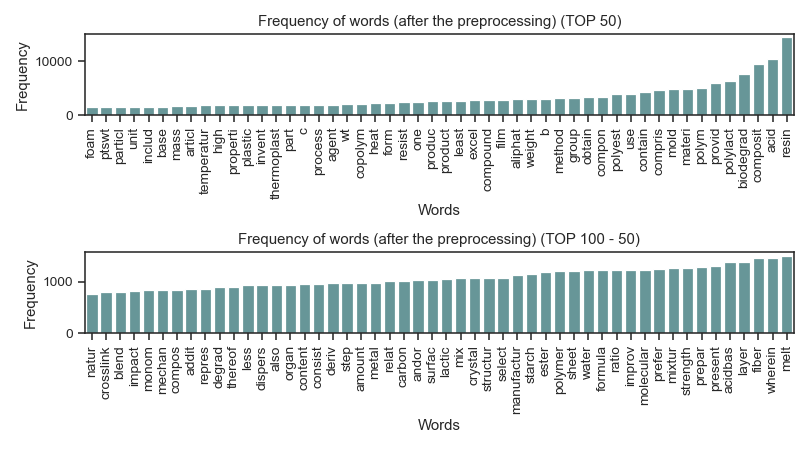

In [270]:
# Create a plot
plt.figure(figsize=(9,5))
plt.subplot(2,1,1)
sns.barplot(x=list(frequency_after_sorted.keys())[-50:], y=list(frequency_after_sorted.values())[-50:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 50)')

plt.subplot(2,1,2)
sns.barplot(x=list(frequency_after_sorted.keys())[-100:-50], y=list(frequency_after_sorted.values())[-100:-50],
            color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 100 - 50)')

plt.tight_layout()
plt.show()

Most of the words look useful to characterize patents.

### 3.4. Adjust the number of tokens per patent

Some patents would have many tokens, and some might have a few. If a patent has only some tokens, it could be difficult to be compared with others. I decided to remove patents having less than 5 tokens from df_enja_abst_noPunc. 

In [271]:
# Extract the indexes of the patents having less than 5 tokens
few_tokens_index = []
for i in range(len(tokens_stem_list)):
    if len(tokens_stem_list[i]) < 5:
        few_tokens_index.append(i)

print('The number of patents having less than 5 tokens:', len(few_tokens_index))

The number of patents having less than 5 tokens: 131


In [272]:
# Make a new column, 'Tokens', and assign the token list
df_enja_abst_noPunc['Tokens'] = tokens_stem_list

# Removes rows having less than 5 tokens
df_enja_abst_more5 = df_enja_abst_noPunc.drop(df_enja_abst_noPunc.index[few_tokens_index])

print('The number of rows of df_enja_abst_more5', len(df_enja_abst_more5))
print('df_enja_abst_more5 (first two rows):')
df_enja_abst_more5.head(2)

The number of rows of df_enja_abst_more5 7355
df_enja_abst_more5 (first two rows):


,Application_Id,Title,Abstract,Tokens
3,US293704217,BIODEGRADABLE URINE COLLECTOR,A singleuse biodegradable paper urine collector and method of using same the urine collector including a funnel body having a sloped continuous sidewall a sloped base a top opening a funnel hole located at the lowest region of the sloped base and optionally a urine sample container operatively coupled to the sloped base To convey funneled urine into the container a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole,"[singleus, biodegrad, paper, urin, collector, method, use, urin, collector, includ, funnel, bodi, slope, continu, sidewal, slope, base, top, open, funnel, hole, locat, lowest, region, slope, base, option, urin, sampl, contain, oper, coupl, slope, base, convey, funnel, urin, contain, top, edg, contain, posit, within, funnel, hole, base, contain, posit, outsid, funnel, bodi, funnel, bodi, configur, funnel, stream, urin, top, open, along, interior, surfac, funnel, bodi, toward, funnel, hole]"
4,JP293331568,抗血小板粘着性を示す生分解性共重合体,It combines the biodegradability and antithrombotic also excellent in shape stability to provide a biodegradable copolymer to exhibit antiplatelet adhesion of the novel structure unprecedented An aliphatic Poriesueru a copolymer of a hydrophobic component and a hydrophilic component the hydrophilic component is poly 15dioxepan2one poly 14dioxan2 on or comprises at least one of polyethylene oxide the molar ratio of the hydrophilic component is 85 or less than 5 the raw shows the antiplatelet adhesion degradable copolymer,"[combin, biodegrad, antithrombot, also, excel, shape, stabil, provid, biodegrad, copolym, exhibit, antiplatelet, adhes, novel, structur, unpreced, aliphat, poriesueru, copolym, hydrophob, compon, hydrophil, compon, hydrophil, compon, poli, 15dioxepan2on, poli, 14dioxan2, compris, least, one, polyethylen, oxid, molar, ratio, hydrophil, compon, less, raw, show, antiplatelet, adhes, degrad, copolym]"


In [273]:
# Make a new token_list from df_enja_abst_noPunc
token_list_np = np.array(df_enja_abst_more5['Tokens'])

print('token_list_np (first 5 tokens of the first patent):')
token_list_np[0][:5]

token_list_np (first 5 tokens of the first patent):


['singleus', 'biodegrad', 'paper', 'urin', 'collector']

This list is used for the sentence similarity calculation. Next, check the distribution of the number of tokens per patent.

<IPython.core.display.Javascript object>


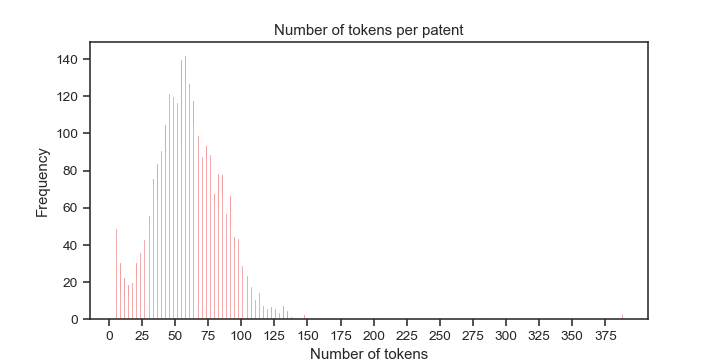

In [274]:
# Count the number of tokens per product
number_token_list = [len(tokens) for tokens in token_list_np]

# Draw a bar plot
plt.figure(figsize=(8,4))

plt.hist(number_token_list, bins=max(number_token_list)-min(number_token_list), color='lightcoral') 
plt.xticks(range(0, max(number_token_list), 25))
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Number of tokens per patent') 

plt.show()

In [275]:
# Show the summary statistics as a DataFrame
print('The summary statistics of the number of tokens per patent:')
pd.DataFrame(pd.Series(number_token_list).describe(percentiles=[0.25, 0.75, 0.9])).transpose()

The summary statistics of the number of tokens per patent:


,count,mean,std,min,25%,50%,75%,90%,max
0,7355.0,60.347383,26.569149,5.0,43.0,59.0,77.0,93.0,388.0


The minimum number of tokens per patent became 5. The patents without an abstract and which titles were used as the abstracts would have relatively fewer tokens. This might affect the calculation of the similarities between patents. 

## 4. Modeling

The recommendation system has two main features, using a sentence similarity and a network, to recommend applications. When a patent is given by a user, the neighbor patents (that share IPC codes with the given patent) are extracted. The neighbor patents are sorted by the similarities of the abstracts. Then, the application IPC codes are extracted from the top patents. First, calculate the sentence similarities between patents in df_enja_abst_more5. Second, build the network. Finally, create the recommendation system.

4.1. Sentence similarity  
4.2. Build a network  
4.3. Create a recommendation system

### 4.1. Sentence similarity

Tf-idf vectorizer is chosen to transform the token list into a vector so that the importance of each word is standardized. A unigram, bigram, and trigram are used because compound names are often composed of several words. For example, methyl methacrylate, poly (1,5-dioxepan-2-one), or poly (ethylene -co- acrylic acid). They should be considered in the calculation. To reduce the complexity, the tokens appearing less than 3 patents are ignored.   

In [276]:
# Vectorization
def dummy_tokened(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=dummy_tokened, lowercase=False, ngram_range=(1, 3), min_df=3)
vecs = vectorizer.fit_transform(token_list_np)

# Get the feature names
feature_names = vectorizer.get_feature_names()

# Show the shape of bow_dog
print('tfidf matrix: vecs')
print('Matrix shape:', vecs.shape)

tfidf matrix: vecs
Matrix shape: (7355, 45437)


Use cosine similarity to calculate the sentence similarities. Cosine similarity is often used to measure the similarities between texts.

In [277]:
# Calculate the cosine similarities
cs_array = np.round(cosine_similarity(vecs.toarray(), vecs.toarray()),3)

# Store the similarities in a new DataFrame
df_similarities = pd.DataFrame(cs_array, 
                               index=df_enja_abst_more5['Application_Id'], 
                               columns=df_enja_abst_more5['Application_Id'])

print('df_similarities (first 5 rows):')
df_similarities.head()

df_similarities (first 5 rows):


Application_Id,US293704217,JP293331568,WO2020059793,JP290898185,WO2020066679,WO2020084945,JP290898180,JP293031281,RU291513243,RU282814286,...,CA284258825,CA94508293,CA94882924,CA124239679,CA160355655,CA94262256,CA93908381,CA224370974,CA93894881,CA189885070
Application_Id,,,,,,,,,,,,,,,,,,,,,
US293704217,1.000,0.002,0.003,0.013,0.006,0.035,0.016,0.002,0.006,0.019,...,0.004,0.034,0.008,0.003,0.002,0.008,0.000,0.027,0.026,0.039
JP293331568,0.002,1.000,0.006,0.021,0.001,0.031,0.017,0.042,0.018,0.034,...,0.006,0.010,0.036,0.015,0.002,0.036,0.018,0.015,0.016,0.045
WO2020059793,0.003,0.006,1.000,0.015,0.006,0.224,0.026,0.001,0.020,0.017,...,0.003,0.009,0.024,0.018,0.002,0.024,0.006,0.005,0.002,0.013
JP290898185,0.013,0.021,0.015,1.000,0.007,0.038,0.020,0.014,0.066,0.030,...,0.005,0.033,0.084,0.022,0.021,0.084,0.018,0.015,0.043,0.011
WO2020066679,0.006,0.001,0.006,0.007,1.000,0.021,0.012,0.002,0.003,0.008,...,0.003,0.006,0.002,0.004,0.005,0.002,0.004,0.001,0.033,0.013


To evaluate the accuracy, the number of common IPC codes is counted. IPC codes are not exhaustively assigned, but the tendency will be shown.

In [301]:
# Evaluate the accuracy
# Get patent IDs having an English or Japanese abstract
enja_patents = df_enja_abst_nopunc['Application_Id']
# Make a list to store the number of the common IPC codes to each one of enja_patents 
n_common_ipc_list = []

# Sort patent IDs by the similarities to each patent, and count the number of common IPC codes
for patent in tqdm(enja_patents):
    # IPC codes of a current target patent
    target_ipcs = patent_ipc_dic[patent]
    # Get the patent IDs in the descending order
    similar_patents = df_similarities.loc[patent].sort_values(ascending=False).index
    
    # Make a list to store the number of the common IPC codes
    n_common_ipcs = []
    
    # Extract similar_patents' IPC codes, and count the number of common IPC codes
    for sim_patent in similar_patents:
        # Get the IPC codes of the similar patent
        similar_patent_ipcs = patent_ipc_dic[sim_patent]
        # Count the number of common IPC codes
        n_common_ipc = len(set(target_ipcs) & set(similar_patent_ipcs))
        # Add the number in n_common_ipcs
        n_common_ipcs.append(n_common_ipc)
    
    # Add the list in n_common_ipc_list
    n_common_ipc_list.append(n_common_ipcs)    

# Transform the list to numpy array for later
n_common_ipc_array = np.array(n_common_ipc_list)

# Calculate the means of common IPC codes
mean_n_common_ipcs = np.mean(n_common_ipc_array, axis=0)
# Calculate the mean of the means
mean_mean_n_common_ipcs = np.mean(mean_n_common_ipcs)

100%|██████████████████████████████████████| 7355/7355 [01:22<00:00, 89.53it/s]


array([[ 3,  0,  0, ...,  0,  0,  0],
       [11,  0,  0, ...,  0,  0,  0],
       [ 6,  0,  0, ...,  0,  0,  0],
       [ 5,  1,  1, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0]])

<IPython.core.display.Javascript object>


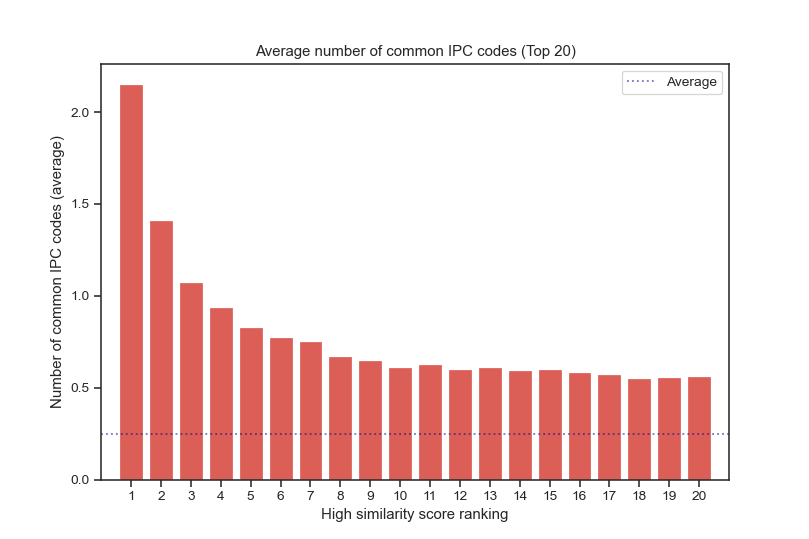

In [430]:
# Create a bar plot
plt.figure(figsize=(9,6))

# Plot from the second to 21st (because the first one is the number of IPC codee of itselt)
plt.bar(range(1, len(mean_n_common_ipcs[1:21])+1), mean_n_common_ipcs[1:21]) # c='lightcoral'
plt.xlabel('High similarity score ranking')
plt.ylabel('Number of common IPC codes (average)')
plt.xlim([0,21])
plt.xticks(np.arange(1, 21, 1))
plt.axhline(xmin=0, xmax=21, y=mean_mean_n_common_ipcs, c='navy', alpha=0.5, ls=':', label='Average')

plt.legend()
plt.title('Average number of common IPC codes (Top 20)')

plt.show()

The higher similarity scores, the more common IPC codes. The similarity calculation works well. Use the similarity scores for the recommendation system.

### 4.2. Build a network

Here, the second feature of the recommendation system, a network, is built. 

4.2.1. Create a graph (network)  
4.2.2. Create a patent projection graph

#### 4.2.1. Create a graph (network)

The network is composed of nodes and edges. There are 2 kinds of nodes: patent nodes and IPC code nodes. A patent node is connected to IPC code nodes by edges if the patent has the IPC codes. There are 8,182 patents and 4,344 IPC codes in the data. The number of nodes will be 12,526 in total.

In [435]:
# Instantiate a new Graph
G = nx.Graph()

# Add patent nodes
G.add_nodes_from(df['Application_Id'], bipartite='patent', application=False)

# Add ipc_code nodes
for code in ipc_freq.keys():
    if code[:3] in app_count_dict.keys():
        G.add_node(code, bipartite='ipc', application=True)
    else:
        G.add_node(code, bipartite='ipc', application=False)
        
# Add edged 
for patent, codes in patent_ipc_dic.items():
    for code in codes:
        if code in ipc_freq.keys():
            G.add_edge(patent, code)
            
print('Patent-IPC graph: G')

Patent-IPC graph: G


In [436]:
# The number of nodes and edges
print('The number of nodes:', len(G.nodes()))
print('The number of edges:', len(G.edges()))

The number of nodes: 12526
The number of edges: 46012


(I will add Unit Test here: len(G.nodes()) == len(df) + len(ipc_freq.keys()))

Check how many kinds of applications. Remember some IPC classes were chosen as applications, app_count_dict.

In [431]:
# Count the number of application nodes
n_app = list(nx.get_node_attributes(G, 'application').values()).count(True)

print('Application kinds:', n_app)

Application kinds: 2153


There are 2,153 kinds of applications in the data. The recommended applications will be chosen from them. 

Before making the recommendation system, explore the network. As an example, I extract the network around 'JP271085664'. 

In [310]:
# Extract the neighbors (IPC codes which 'JP271085664' has )
ex_patent = 'JP271085664'
nei_JP271085664_set = set(G.neighbors(ex_patent))

print('The neighbors of "JP271085664" (IPC codes "JP271085664" has ):')
nei_JP271085664_set

The neighbors of "JP271085664" (IPC codes "JP271085664" has ):


{'A61L 31/00', 'C08K 5/521', 'C08L 101/00', 'C08L 67/00'}

In [311]:
# Make a set to store the neighbors of the neighbors
nei_patents_set = set()

# Extract the neighbors of the neighbors
for ipc in nei_JP271085664_set:
    nei_patents_set = nei_patents_set.union(set(G.neighbors(ipc)))

# The number of the nodes
len(nei_patents_set)

2313

The patent, 'JP271085664', has 4 IPC codes, and the 4 IPC codes are connected to 2,313 patents in total. Here, I would like to visualize the network. Because it's very big. I pick up one IPC code, 'A61L 31/00', and visualize the network having nodes of 'JP271085664', the 4 IPC codes and the neighbor patents of 'A61L 31/00'.

In [312]:
# Extract the neighbor patents of 'A61L 31/00'
nei_A61L3100_set = set(G.neighbors('A61L 31/00'))

# Combine the patent nodes and IPC code nodes
neighbors_set = nei_JP271085664_set.union(nei_A61L3100_set)

# Make a subgraph of the neighbors
G_JP271085664 = G.subgraph(neighbors_set)

# Show the number of the nodes
print('The number of the nodes of G_JP271085664:', len(list(G_JP271085664.nodes())))

The number of the nodes of G_JP271085664: 101


Plot the network.

<IPython.core.display.Javascript object>


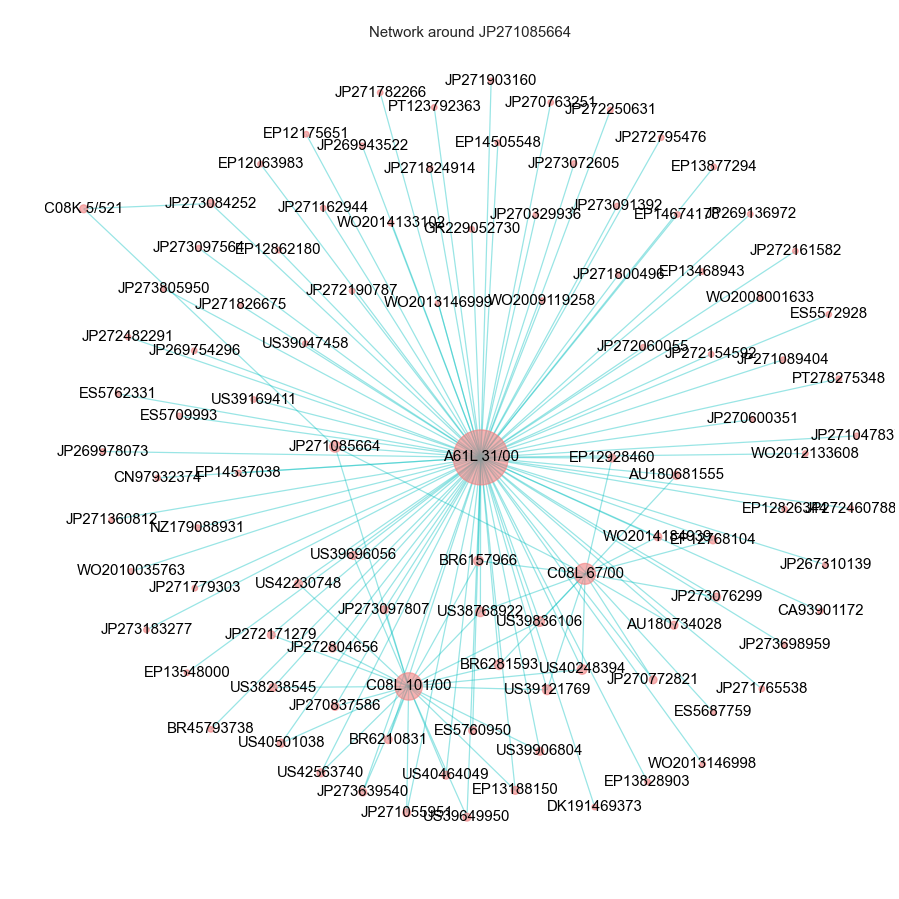

In [434]:
# Make a list to store the node sizes
node_size = []

# Count the number of edges of each nodes, and multiple 20 for the node size
for node in list(G_JP271085664.nodes()):
    n_edges = len(list(G_JP271085664.neighbors(node)))
    node_size.append(n_edges*20)

# Plot the network of G_JP271085664
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G_JP271085664, k=0.1)
nx.draw_networkx_nodes(G_JP271085664, pos, node_color="lightcoral",alpha=0.6, node_size=node_size)
nx.draw_networkx_labels(G_JP271085664, pos, fontsize=1)
nx.draw_networkx_edges(G_JP271085664, pos, alpha=0.4, edge_color='c')

plt.axis('off')
plt.subplots_adjust(left=0.05, right=0.995, bottom=0.05, top=0.95)
plt.title('Network around JP271085664')
plt.show()

'JP271085664' is connected to the 4 IPC codes, 'A61L 31/00', 'C08K 5/521', 'C08L 101/00', 'C08L 67/00'. Then, 'A61L 31/00' has a connection with 97 patents. According to the network plot, 'C08L 101/00' and 'C08L 67/00' have some connections with the patents 'A61L 31/00' is connected to.  
  
This network is a part of the original graph. The whole graph is more highly connected with one another.  

#### 4.2.2. Create a patent projection graph

The graph G has 2 kinds of nodes (patent nodes and IPC code nodes.) Here, I make a new graph having only patent nodes. The new graph is made by projecting the relationships between patent nodes and IPC code nodes. For example, if a patent (P1) has some IPC codes (IPC1 and IPC2) and another patent (P2) has some IPC codes (IPC1, IPC3), it is said that P1 and P2 are indirectly connected through IPC1. In this case, the new graph will have an edge between P1 and P2.  
  
Create a patent projection graph.

In [437]:
# Get the patent nodes
patent_nodes = [node for node, metadata in G.nodes(data=True) if metadata['bipartite'] == 'patent']

# Create the patent node projection 
G_patents = nx.bipartite.projected_graph(G, nodes=patent_nodes)

print('Patent projection graph: G_patents')

# The number of nodes and edges
print('The number of nodes:', len(G_patents.nodes()))
print('The number of edges:', len(G_patents.edges()))

Patent projection graph: G_patents
The number of nodes: 8182
The number of edges: 7035567


Degree centrality is a rate of the number of edges to the potential number of edges. For example, if it is 1, the node is connected to all the other nodes, and if it is 0.5, the node is connected to the half of the other nodes.  
  
Visualize the degree centrality distribution of the patent projection. 

<IPython.core.display.Javascript object>


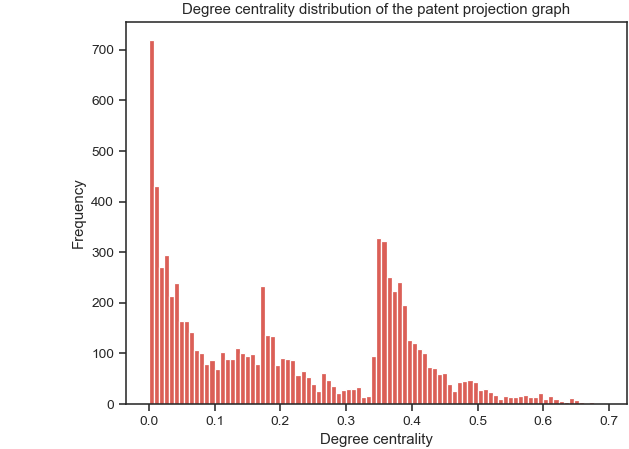

In [439]:
# Calculate the degree centrality 
degree_centrality_patent = nx.degree_centrality(G_patents)

# Plot the histogram of degree centrality values
plt.figure(figsize=(7,5))
plt.hist(list(degree_centrality_patent.values()), bins=int(np.sqrt(len(G_patents.nodes()))))

plt.xlabel('Degree centrality')
plt.ylabel('Frequency')

plt.title('Degree centrality distribution of the patent projection graph') 

plt.subplots_adjust(left=0.2, right=0.995, bottom=0.1, top=0.95)
plt.show() 

There are 3 peak tops around 0, 0.18, and 0.36. Because the graph has 8,182 nodes, 0.18 means more than 1470 connections and it is a lot. That is why the sentence similarity is going to be used to prioritize them. On the other hand, if a degree centrality is very close to 0, the patent has only a few edges (connections with the other patents). Then, the neighbor patents might or might not be connected to the other patents. If not, the network is closed. In the graph, all of the patent nodes might not be connected. In the case, the graph is composed of some subgraphs. Check the number of subgraphs and the number of patents in each subgraph.

In [332]:
# Number of subgraphs
subgraphs_patents = list(nx.connected_components(G_patents))

print('The number of subgraphs in the patent projection graph:', len(subgraphs_patents))

The number of subgraphs in the patent projection graph: 46


<IPython.core.display.Javascript object>


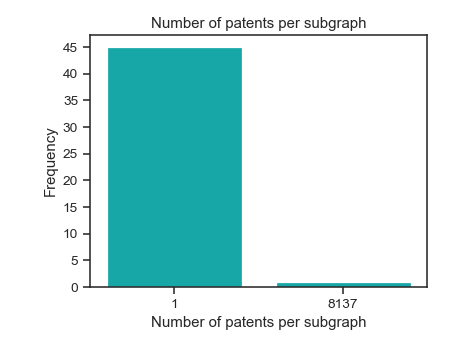

In [333]:
# Count the number of patents in each subgraph
n_subgraphs_patents = list(map(lambda patents: len(patents), subgraphs_patents))

# Draw a count plot
plt.figure(figsize=(5,4))

sns.countplot(x=n_subgraphs_patents, color='c')
plt.ylabel('Frequency')
plt.xlabel('Number of patents per subgraph')
plt.title('Number of patents per subgraph')
plt.yticks(range(0, 50, 5))

plt.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.90)
plt.show()

There are one huge subgraph and 45 small subgraphs. The small subgraphs have only one component, that is, each subgraph is composed of one patent. They don't have any neighbor patents, and it's impossible to extract the applications from the neighbors. On the other hand, all patents are connected by 'C08L 101/16' actually. Then, in the case, recommended applications will be extracted from patents having the most similar abstract. 

### 4.3. Create a recommendation system

Finally, create a recommendation system. I make 2 versions of the recommendation system. The first one accepts one patent from a user and recommends up to 10 applications. The second one accepts 2 IPC codes from a user and recommends up to 10 applications.

4.3.1. Create a recommendation system accepting one patent as an input  
4.3.2. Create a recommendation system accepting 2 IPC codes as an input

#### 4.3.1. Create a recommendation system accepting one patent as an input

When a user already published a patent in the biodegradable polymer field and wants to know other potential applications for their polymer, this recommendation system would be used. The patent a user inputted should be in the data. The patent could be a competitor's patent. For example, suppose that Company_A published Patent_1 about a biodegradable suture using　polyglycolide, and they want to know that their polyglycolide could be used for the other applications. They would input Patent_1 in the system, and would get 10 potential applications. 

This is the flow:  <img src="system_1.png" width="700px">

In [400]:
# Recommend applications from one patent
def recommend_app_from_patent(patent_id):
    '''
    Recommend up to 10 applications when one patent number (Application_Id). is given. 
    The input patent should be included in the original data.
    ''' 
    # Print the patent id a user input
    print('Patent ID you input:', patent_id)
    
    # Check if the patent number is in the system
    if patent_id not in list(G_patents.nodes()):
        print('The patent number is not acceptable. Check the format, e.g. "JP272810309", use the other patent, or use IPC codes instead. [Error1]')
    else:
        neighbor_patents = set(G_patents.neighbors(patent_id))
        # For counting patents checked
        checked_patents = set([patent_id])
        # For counting IPC codes checked
        checked_ipcs = set(G.neighbors(patent_id))
        # For collecting reference patents and application IPC codes (this is what we want)
        appIpc_refPatents = {}
        
        # Continue the loop until getting 10 recommended applications
        while len(appIpc_refPatents) < 10:
            # For tempolaly keeping patent IDs and the similarities
            id_simi_dic = {}
            
            # Get similar patents from the similarities when there is no neighbor
            if len(neighbor_patents) == 0:
                if patent_id in df_similarities.columns:
                    print("** Rough estimate because there is no neighborhood patent and the patent doesn't have English or Japanese abstract**")
                    patents_simi_order = df_similarities.loc[patent_id].sort_values(ascending=False).index
                # Show the error message when the patent id is not in the similarity dataframe
                else: 
                    print('The patent number is not acceptable. Use the other patent, or use IPC codes instead. [Error2]')
                    break
            else:            
                if patent_id in df_similarities.columns:
                    # Get the similarities of the neighbor patents
                    
                    for patent1 in neighbor_patents:
                        
                        if patent1 in df_similarities.columns:
                            id_simi_dic[patent1] = df_similarities.loc[patent_id, patent1]
                        # Get the mean as the similarity when the patent doesn't have the similarity
                        else:
                            id_simi_dic[patent1] = df_similarities.loc[patent_id].mean()
                    
                    # Sort the dictionary by the similarities
                    id_simi_dic_sorted = sorted(id_simi_dic.items(), key=lambda x: x[1], reverse=True)
                    # Get the patent ids
                    patents_simi_order = list(map(lambda tup: tup[0], id_simi_dic_sorted))
                else:
                    print("*** Rough estimate because the abstract doesn't exist or is not in English or Japaneese ***")
                    patents_simi_order = list(neighbor_patents)
            
            # Get application IPC codes of the neighbor patents
            for patent2 in patents_simi_order:
                checked_patents.add(patent2)
                nei_ipc = set(G.neighbors(patent2)) - checked_ipcs
                
                # Break flag
                break_loop = False
                
                for ipc in nei_ipc:
                    checked_ipcs.add(ipc)
                    
                    # Get the IPC code if it is an application IPC code
                    if ipc[:3] in app_count_dict.keys():
                        appIpc_refPatents[ipc] = patent2
                        # Stop the search if we already have 10 recommended applications
                        
                        if len(appIpc_refPatents) == 10:
                            print('Recommended application codes and the reference patents:')
                            print(pd.DataFrame({'Application IPC Code': list(appIpc_refPatents.keys()),
                                                'Reference Patent': list(appIpc_refPatents.values())}))
                            break
                            
                if break_loop:
                    break
                    
            # Get the neighbor patents of the neighbor patents
            if len(appIpc_refPatents) < 10:
                # Because neighbor_patents will be modufied for next loop
                neighbor_patents_iter = list(neighbor_patents)
                neighbor_patents = set()
                
                for patent in neighbor_patents_iter:
                    neighbor_patents = neighbor_patents.union(set(G_patents.neighbors(patent)))
                    
                neighbor_patents = neighbor_patents - checked_patents

(I will add Unit Test here: The system works to all of the patents in the data. Show an appropriate error if needed.)

In [401]:
# Example 1
patent = random.choice(df['Application_Id'])
recommend_app_from_patent(patent)

Patent ID you input: JP268664209
Recommended application codes and the reference patents:
  Application IPC Code Reference Patent
0          C09J 201/00      JP268478790
1            C09J 7/02      JP268478790
2           A61L 31/06       EP12208204
3           A61L 17/12       EP12208204
4            B41M 3/00      JP268561255
5            H05K 3/20      JP268561255
6            H05K 1/03      JP268561255
7            G02B 1/04      JP273229085
8            H01C 7/02      JP268427817
9            B41M 5/26      JP268565569


In [402]:
# Example 2: one component in a subgraph
patent = 'ID202886819'
recommend_app_from_patent(patent)

Patent ID you input: ID202886819
The patent number is not acceptable. Use the other patent, or use IPC codes instead. [Error2]


#### 4.3.2. Create a recommendation system accepting 2 IPC codes as an input

When a user does not have any target patent and wants to search for some applications from IPC codes, this second recommendation system would be used. The IPC codes inputted by a user should be in the data.  
  
For example, suppose that CompanyB is developing a biodegradable suture using polyglycolide (they do not have the patent yet), and wants to know other potential applications for their polymer. They would search the IPC codes of polyglycolide (C08G 63/06) and a biodegradable suture (A61L 17/06, A61L 17/08, or A61L 17/12 (IPC is a hierarchic structure. I recommend to try several IPC codes that are related to what you want to search).) Then, you input 2 IPC codes (e.g. C08G 63/06 and A61L 17/08) into the system and would get up to 10 potential applications.  

This is the flow:  <img src="system_2.png" width="700px">

In [405]:
# Recommend applications from one patent
def recommend_app_from_2ipcs(ipc1, ipc2):
    '''
    Recommend up to 10 applications when two IPC codes (Application_Id). are given. 
    The IPC codes should be included in the original data.
    ''' 
    # Print the IPC codes a user input
    print('IPC codes input:', ipc1, ',', ipc2)
    
    # Check if the IPC codes are in the system
    if ipc1 not in list(G.nodes()):
        print('The first IPC code is not acceptable. Check the format, e.g. "C08L 101/16", use the other IPC codes instead. [Error1]')
    elif ipc2 not in list(G.nodes()):
        print('The second IPC code is not acceptable. Check the format, e.g. "C08L 101/16", use the other IPC codes instead. [Error2]')
    else:
        # For counting IPC codes checked
        checked_ipcs = set([ipc1, ipc2])

        # Get the neighbor patents for each IPC code
        frontier_patents_1 = set(G.neighbors(ipc1))
        frontier_patents_2 = set(G.neighbors(ipc2))
        
        # To keep patents close to each IPC code
        neighbor_patents_1 = set(frontier_patents_1)
        neighbor_patents_2 = set(frontier_patents_2)

        # Get the intersection
        intersection_12 = neighbor_patents_1 & neighbor_patents_2
                
        # To keep frontier patents
        frontiers = frontier_patents_1.union(frontier_patents_2)
        
        # Get the closest common patents
        while len(frontiers) != 0:
            
            # Go two next step if already having common patents
            if len(intersection_12) != 0:
                break
            else:
                # To keep frontier patents temporary
                frontier_patents_1_temp = set()
                frontier_patents_2_temp = set()
                
                # Get the frontier patents
                for patent1 in frontier_patents_1:
                    frontier_patents_1_temp = frontier_patents_1_temp.union(set(G_patents.neighbors(patent1)))
                for patent2 in frontier_patents_2:
                    frontier_patents_2_temp = frontier_patents_2_temp.union(set(G_patents.neighbors(patent2)))
                
                # Only get new patents as frontier_patents
                frontier_patents_1 = frontier_patents_1_temp - neighbor_patents_1
                frontier_patents_2 = frontier_patents_2_temp - neighbor_patents_2
                
                # Keep the new patents in each IPC code group
                neighbor_patents_1 = neighbor_patents_1.union(frontier_patents_1)
                neighbor_patents_2 = neighbor_patents_2.union(frontier_patents_2)
                
                # Get the intersection
                intersection_12 = neighbor_patents_1 & neighbor_patents_2
                
                # Combine frontier_patens_1 and _2
                frontiers = frontier_patents_1.union(frontier_patents_2)
        

        # Show the error if we couldn't find any common patent, and end the searching
        if len(frontiers) == 0:
            print('The connection between the two IPC codes was not found. Please try a different combination. [Error3]')
                
        else:
            # For counting patents checked
            checked_patents = set()
            
            # For collecting reference patents and application IPC codes (this is what we want)
            appIpc_refPatents = {}
        
            # Continue the loop until getting 10 recommended applications
            while len(appIpc_refPatents) < 10:
                # Get application IPC codes of the neighbor patents
                nei_ipc = []
                
                for patent3 in intersection_12: 
                    checked_patents.add(patent3)
                    nei_ipc.extend(set(G.neighbors(patent3)) - checked_ipcs)
                    
                # Count each IPC code
                nei_ipc_count = Counter(nei_ipc)
                
                # Sort the dictionary by the frequency
                nei_ipc_count_sorted = sorted(nei_ipc_count.items(), key=lambda x: x[1], reverse=True)
                
                # Sort by frequent order and the IPC codes
                nei_ipc_sorted = list(map(lambda tup: tup[0], nei_ipc_count_sorted))
                    
                # Break flag
                break_loop = False
                  
                for ipc in nei_ipc_sorted:
                    checked_ipcs.add(ipc)
                    
                    # Get the IPC code if it is an application IPC code
                    if ipc[:3] in app_count_dict.keys():
                        appIpc_refPatents[ipc] = set(G.neighbors(ipc)) & intersection_12
                        # Stop the search if we already have 10 recommended applications
                        
                        if len(appIpc_refPatents) == 10:
                            break_loop = True
                            print('Recommended application codes and the reference patents:')
                            print(pd.DataFrame({'Application IPC Code': list(appIpc_refPatents.keys()),
                                                'Reference Patent': list(appIpc_refPatents.values())}))
                            break
                                
                if break_loop:
                    break
                

                # Get the neighbor patents of neighbor patents
                if len(appIpc_refPatents) < 10:
                    # Because intersection_12 will be modified for next loop
                    intersection_12_temp = list(intersection_12)
                    intersection_12 = set()
                        
                    for patent4 in intersection_12_temp:
                        intersection_12 = intersection_12.union(set(G_patents.neighbors(patent4)))
                        
                    intersection_12 = intersection_12 - checked_patents
                    
                    if len(intersection_12) != 0:
                        # For tempolaly keeping patent IDs and the similarities
                        id_simi_dic = dict([(i,0) for i in intersection_12])
                    
                        for patent5 in intersection_12_temp:
                            
                            if patent5 in df_similarities.columns:
                                # Get the similarities of the neighbor patents
                                for patent6 in intersection_12:
                                    if patent6 in df_similarities.columns:
                                        if id_simi_dic[patent6] < df_similarities.loc[patent5, patent6]:
                                            id_simi_dic[patent6] = df_similarities.loc[patent5, patent6]
                                    # Get the mean as the similarity when the patent doesn't have the similarity
                                    else:
                                        id_simi_dic[patent6] = df_similarities.loc[patent5].mean()
                    
                        # Sort the dictionary by the similarities
                        id_simi_dic_sorted = sorted(id_simi_dic.items(), key=lambda x: x[1], reverse=True)
                        # Get the top 10 similar patents and assign them as intersection_12
                        intersection_12 = set(list(map(lambda tup: tup[0], id_simi_dic_sorted))[:10])
                            
                    else:
                        print('Recommended application codes and the reference patents:')
                        print(pd.DataFrame({'Application IPC Code': list(appIpc_refPatents.keys()),
                                                'Reference Patent': list(appIpc_refPatents.values())}))
                        break

(I will add Unit Test here: The system works to random 100 IPC code combinations. Show an appropriate error if needed.)

In [410]:
# Example 1
patent = random.sample(list(ipc_freq.keys()), 2)
recommend_app_from_2ipcs(patent[0], patent[1])

IPC codes input: G03C 1/685 , B43K 5/02
Recommended application codes and the reference patents:
  Application IPC Code Reference Patent
0           C09K 21/14    {JP268547546}
1           C09K 21/12    {JP268547546}
2           C09K 21/02    {JP268547546}
3           C09K 21/04    {JP268547546}
4           C09K 21/10    {JP268547546}
5           C09K 21/06    {JP268684805}
6           C09K 21/00     {US43488062}
7            C09K 3/10    {JP271479964}
8            G02B 1/04    {JP270814271}
9            A01G 9/14    {JP270713333}


## 5. Recommend Applications (using the model)

Coming soon!